In [1]:
from data_preparation.spatio_temporal_filtering import get_bd_data
from data_preparation import read_all_granularity_data
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from data_preparation import country_color_dict
from scipy.stats import pearsonr

metadata_all, series_all, metadata_region_all, region_series_all, metadata_country_all, country_series_all = read_all_granularity_data()
metadata, series, metadata_region, region_series, metadata_country, country_series = get_bd_data()

# Leader Follower Demonstration

We keep follower constant then shift leader values. The positive shifted value for leader denotes that leader leads. For example shifting leader by 2 units yields max corr value then we say leader leads the follower by 2 units.

In [ ]:
follower = pd.Series([1,1,1,1,1,1,2,2,3,3,2,2,1,1,1,1,1,1])
leader = pd.Series([1,1,1,1,2,2,3,3,2,2,1,1,1,1,1,1,1,1])
leader = leader * 3
# leader = [1,1,1,1,1,2,2,3,3,2,2,1,1,1,1,1,1,1]

# leader = [1,1,1,1,1,1,2,2,2,2,2,2]
# leader = [2,1,1,1,1,1,1,2,2,2,2,2]

print(pearsonr(follower,leader.shift(-2).fillna(0)),pearsonr(follower,leader),pearsonr(follower,leader.shift(2).fillna(0)))

fig = go.Figure()
x_axis = np.arange(18)

fig.add_trace(go.Scatter(x=x_axis, y=follower,
                    mode='lines',
                    name='follower'))

fig.add_trace(go.Scatter(x=x_axis, y=leader,
                    mode='lines',
                    name='leader'))

fig.add_trace(go.Scatter(x=x_axis, y=leader.shift(2),
                    mode='lines',
                    name='leader shift 2'))

# fig.add_trace(go.Scatter(x=x_axis, y=leader.shift(-2),
#                     mode='lines',
#                     name='leader shift -2'))

fig.show()

In [ ]:
series_all

In [ ]:
range_iter = range(-12, 12 + 1)
for i in range(8):
    # subseries = region_series_all[f'2018-0{i + 1}-01':f'2018-0{i + 2}-01']
    subseries = series_all[f'2018-01-07':f'2018-01-14']
    # cross_corr = pd.Series([subseries.Rajshahi.corr(subseries.NCT.shift(j)) for j in range_iter], index=range_iter)
    cross_corr = pd.Series([subseries.Rajshahi_Rajshahi.corr(subseries.Delhi_NCT.shift(j)) for j in range_iter], index=range_iter)
    print(subseries.shape)
    print(cross_corr.idxmax())
    # fig = px.bar(cross_corr)
    # fig.show()

In [ ]:
subseries = region_series_all[f'2021-0{0 + 1}-01':f'2021-0{0 + 2}-01']
subseries

In [ ]:
series_for_cc = region_series_all
series_for_cc.shape

In [ ]:
metadata_region_all

In [ ]:
date_range_start = pd.date_range(start='1/1/2019', end='1/1/2022', closed='left', freq="D")
# date_range_start = pd.date_range(start='1/1/2019', end='1/1/2020', closed='left', freq="7D")
# date_range_start = pd.date_range(start='2019-01-01 00:00:00', end='2019-01-03 00:00:00', closed='left')
date_range_end = date_range_start + pd.DateOffset(days=14) - pd.DateOffset(hours=1)


# date_range_start = pd.date_range(start='1/1/2019', end='1/1/2022', closed='left', freq="6H")
# date_range_end = date_range_start + pd.DateOffset(days=1) - pd.DateOffset(hours=1)

date_range_start,date_range_end

In [ ]:
def compute_lag_stats():
    lag_stats = []
    for start_date,end_date in zip(date_range_start,date_range_end):
        print(start_date,end_date)
        # for leader in region_series.columns[:]:
        for leader in metadata_region_all.index[metadata_region_all.Country=='India']:
            leader_series = series_for_cc[leader]
            for lag in range(0,6):
                leader_series_shifted = leader_series.shift(lag)[start_date:end_date]
                # print(leader_series_shifted)
                # for follower in region_series.columns[:]:
                for follower in metadata_region_all.index[metadata_region_all.Country=='Bangladesh']:
                    follower_series = series_for_cc[follower]
                    # print(leader_series.corr(follower_series))
                    corr = leader_series_shifted.corr(follower_series)
                    lag_stats.append([start_date,end_date,leader,follower,lag,corr])
    lag_stats_df = pd.DataFrame(lag_stats,columns=['start_date','end_date','leader','follower','lag','corr'])
    lag_stats_df.sort_values(['start_date','leader','follower'])
    return lag_stats_df

lag_stats_df = compute_lag_stats()

In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr
import statsmodels.api as sm
import pandas as pd
import numpy as np

def analyze_comparative_transport(series_for_cc, metadata_region_all, date_range_start, date_range_end,
                                max_lag=6):
    """
    Analyze pollution transport with very relaxed criteria for detecting transport patterns
    """
    transport_evidence = []

    for start_date, end_date in zip(date_range_start, date_range_end):
        window_data = series_for_cc[start_date:end_date].copy()
        print(start_date,end_date)

        india_zones = metadata_region_all[metadata_region_all.Country=='India'].index
        bangladesh_zones = metadata_region_all[metadata_region_all.Country=='Bangladesh'].index

        for india_zone in india_zones:
            india_series = window_data[india_zone]

            for bangladesh_zone in bangladesh_zones:
                bangladesh_series = window_data[bangladesh_zone]

                # Even more relaxed missing value criterion (from 40% to 50%)
                if india_series.isna().sum() > len(india_series) * 0.5 or \
                   bangladesh_series.isna().sum() > len(bangladesh_series) * 0.5:
                    continue

                results = {}
                results['start_date'] = start_date
                results['end_date'] = end_date
                results['india_zone'] = india_zone
                results['bangladesh_zone'] = bangladesh_zone

                valid_data_zero = pd.concat([india_series, bangladesh_series], axis=1).dropna()
                if len(valid_data_zero) >= 24:
                    zero_lag_corr, zero_lag_pval = pearsonr(valid_data_zero.iloc[:, 0],
                                                           valid_data_zero.iloc[:, 1])
                else:
                    continue

                results['zero_lag_correlation'] = zero_lag_corr
                results['zero_lag_pvalue'] = zero_lag_pval

                # Check all positive lags
                max_corr = zero_lag_corr
                max_corr_lag = 0
                all_lags_corr = [zero_lag_corr]
                all_lags_pval = [zero_lag_pval]
                valid_data = []

                for lag in range(1, max_lag + 1):
                    india_shifted = india_series.shift(lag)
                    valid_data = pd.concat([india_shifted, bangladesh_series], axis=1).dropna()

                    if len(valid_data) >= 24:  # Using same relaxed requirement
                        corr, p_val = pearsonr(valid_data.iloc[:, 0], valid_data.iloc[:, 1])
                        all_lags_corr.append(corr)
                        all_lags_pval.append(p_val)

                        # Update max correlation if this lag shows stronger correlation
                        # Did not change to use absolute values for comparison as postive max correlation is needed
                        if corr > max_corr:
                            max_corr = corr
                            max_corr_lag = lag

                # Add debugging information
                results['max_correlation'] = max_corr
                results['max_correlation_lag'] = max_corr_lag
                results['all_lags_correlation'] = all_lags_corr
                results['all_lags_pvalue'] = all_lags_pval

                # Very relaxed criteria for transport detection
                transport_detected = False
                p_value_diff = 1

                if max_corr_lag > 0:  # If best correlation is at non-zero lag
                    # Calculate if the difference in correlations is significant
                    z_diff = np.arctanh(max_corr) - np.arctanh(zero_lag_corr)
                    se_diff = np.sqrt(1/(len(valid_data_zero)-3) + 1/(len(valid_data)-3))
                    z_stat = z_diff/se_diff
                    p_value_diff = 2*(1 - stats.norm.cdf(abs(z_stat)))

                    # Store diagnostic values
                    results['z_diff'] = z_diff
                    results['z_stat'] = z_stat
                    results['p_value_diff'] = p_value_diff

                    # Much more relaxed conditions for transport detection:
                    # 1. Increased p-value threshold to 0.20
                    # 2. Only requiring the non-zero lag correlation to be very slightly higher
                    # 3. Added an OR condition for strong correlations regardless of p-value

                    # transport_detected = (
                    #     (p_value_diff < 0.05 and max_corr > zero_lag_corr * 0.90) or  # Relaxed significance test
                    #     (max_corr > zero_lag_corr and abs(max_corr) > 0.5)  # Strong correlation condition
                    # )

                    transport_detected = (p_value_diff< 0.05) or (max_corr > 0.5)

                    # transport_detected = (p_value_diff < 0.1)

                if transport_detected:
                    print(bangladesh_zone,india_zone)

                results['transport_detected'] = transport_detected
                results['correlation_diff_pvalue'] = p_value_diff if max_corr_lag > 0 else 1.0

                # Add seasonal information
                month = pd.to_datetime(start_date).month
                results['season'] = (
                    'Winter' if month in [12, 1, 2] else
                    'Spring' if month in [3, 4, 5] else
                    'Summer' if month in [6, 7, 8] else
                    'Fall'
                )

                transport_evidence.append(results)

    evidence_df = pd.DataFrame(transport_evidence)

    # Print diagnostic information
    if not evidence_df.empty:
        print("\nDiagnostic Summary:")
        print(f"Total cases analyzed: {len(evidence_df)}")
        print(f"Cases with non-zero lag max correlation: {sum(evidence_df['max_correlation_lag'] > 0)}")
        print("\nFor non-zero lag cases:")
        non_zero_cases = evidence_df[evidence_df['max_correlation_lag'] > 0]
        if not non_zero_cases.empty:
            print(f"Mean max correlation: {non_zero_cases['max_correlation'].mean():.3f}")
            print(f"Mean zero-lag correlation: {non_zero_cases['zero_lag_correlation'].mean():.3f}")
            print(f"Mean p-value diff: {non_zero_cases['correlation_diff_pvalue'].mean():.3f}")

    return evidence_df

def summarize_comparative_evidence(evidence_df):
    """
    Summarize the evidence with additional metrics for weak transport patterns
    """
    summary = {}

    # Overall statistics
    total_windows = len(evidence_df)
    transport_windows = sum(evidence_df['transport_detected'])

    summary['total_windows'] = total_windows
    summary['transport_windows'] = transport_windows
    summary['transport_percentage'] = (transport_windows/total_windows * 100 if total_windows > 0 else 0)

    # Analyze all cases with non-zero lag max correlation
    non_zero_lag_cases = evidence_df[evidence_df['max_correlation_lag'] > 0]
    summary['non_zero_lag_cases'] = len(non_zero_lag_cases)
    summary['non_zero_lag_percentage'] = (len(non_zero_lag_cases)/total_windows * 100 if total_windows > 0 else 0)

    if not non_zero_lag_cases.empty:
        summary['mean_transport_lag'] = non_zero_lag_cases['max_correlation_lag'].mean()
        summary['median_transport_lag'] = non_zero_lag_cases['max_correlation_lag'].median()
        summary['most_common_transport_lag'] = non_zero_lag_cases['max_correlation_lag'].mode().iloc[0]

        # Seasonal breakdown
        seasonal_transport = (non_zero_lag_cases.groupby('season').size() /
                            evidence_df.groupby('season').size() * 100).round(1)
        summary['seasonal_transport_percentage'] = seasonal_transport.to_dict()

        # Most significant transport pairs (including weak patterns)
        top_pairs = non_zero_lag_cases.groupby(['india_zone', 'bangladesh_zone']).agg({
            'transport_detected': 'sum',
            'max_correlation': 'mean',
            'max_correlation_lag': ['mean', 'median'],
            'correlation_diff_pvalue': 'mean'
        }).round(3)

        # Flatten the column names
        top_pairs.columns = ['transport_detected_count', 'max_correlation_mean',
                           'max_correlation_lag_mean', 'max_correlation_lag_median',
                           'correlation_diff_pvalue_mean']

        summary['top_transport_pairs'] = top_pairs

    return summary

def generate_transport_report(evidence_df):
    """
    Generate a detailed report including both strong and weak transport patterns
    """
    summary = summarize_comparative_evidence(evidence_df)

    report = f"""
Transport Analysis Report (Including Weak Patterns):

1. Overall Evidence:
   - Analyzed {summary['total_windows']} time windows
   - Found significant transport patterns in {summary['transport_windows']} windows ({summary['transport_percentage']:.1f}%)
   - Cases with non-zero lag max correlation: {summary['non_zero_lag_cases']} ({summary['non_zero_lag_percentage']:.1f}%)
   - Mean transport lag: {summary['mean_transport_lag']:.1f} hours
   - Median transport lag: {summary['median_transport_lag']:.1f} hours
   - Most common transport lag: {summary['most_common_transport_lag']} hours

2. Seasonal Patterns:
   Transport detection frequency by season:"""

    for season, percentage in summary['seasonal_transport_percentage'].items():
        report += f"\n   - {season}: {percentage:.1f}%"

    report += "\n\n3. Notable Transport Pairs (Including Weak Patterns):"
    top_pairs = summary['top_transport_pairs']
    for idx in top_pairs.sort_values('transport_detected_count').index:
        if top_pairs.loc[idx, 'transport_detected_count']==0:
            continue
        report += f"\n   {idx[0]} → {idx[1]}:"
        report += f"\n      - Transport detected in {top_pairs.loc[idx, 'transport_detected_count']} windows"
        report += f"\n      - Average lag: {top_pairs.loc[idx, 'max_correlation_lag_mean']:.1f} hours"
        report += f"\n      - Mean correlation: {top_pairs.loc[idx, 'max_correlation_mean']:.3f}"

    return report

In [ ]:
date_range_start = pd.date_range(start='1/1/2019', end='1/1/2022', closed='left', freq="23H")
date_range_end = date_range_start + pd.DateOffset(days=7) - pd.DateOffset(hours=1)

In [ ]:
# Run the analysis

evidence_df = analyze_comparative_transport(
    series_for_cc=series_for_cc,
    metadata_region_all=metadata_region_all,
    date_range_start=date_range_start,
    date_range_end=date_range_end
)
evidence_df

In [ ]:
evidence_df.to_csv("evidence_df.csv",index=False)

In [2]:
import ast

evidence_df = pd.read_csv("evidence_df.csv", parse_dates=['start_date','end_date'])
evidence_df["all_lags_correlation"] = evidence_df["all_lags_correlation"].apply(ast.literal_eval)
evidence_df["all_lags_pvalue"] = evidence_df["all_lags_pvalue"].apply(ast.literal_eval)

In [3]:
evidence_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90824 entries, 0 to 90823
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   start_date               90824 non-null  datetime64[ns]
 1   end_date                 90824 non-null  datetime64[ns]
 2   india_zone               90824 non-null  object        
 3   bangladesh_zone          90824 non-null  object        
 4   zero_lag_correlation     90824 non-null  float64       
 5   zero_lag_pvalue          90824 non-null  float64       
 6   max_correlation          90824 non-null  float64       
 7   max_correlation_lag      90824 non-null  int64         
 8   all_lags_correlation     90824 non-null  object        
 9   all_lags_pvalue          90824 non-null  object        
 10  transport_detected       90824 non-null  bool          
 11  correlation_diff_pvalue  90824 non-null  float64       
 12  season                   90824 n

In [4]:
evidence_df.transport_detected.value_counts()/evidence_df.shape[0]*100

False    97.522681
True      2.477319
Name: transport_detected, dtype: float64

In [5]:
evidence_df_transport_detected = evidence_df[evidence_df.transport_detected].copy()
evidence_df_transport_detected['month']=evidence_df_transport_detected['start_date'].dt.month
evidence_df_transport_detected
# evidence_df_transport_detected.bangladesh_zone.value_counts()
# evidence_df_transport_detected.india_zone.value_counts()

start_date            end_date      india_zone bangladesh_zone  \
13    2019-01-01 00:00:00 2019-01-07 23:00:00    Chhattisgarh        Rajshahi   
14    2019-01-01 00:00:00 2019-01-07 23:00:00    Chhattisgarh         Rangpur   
51    2019-01-01 00:00:00 2019-01-07 23:00:00          Odisha          Khulna   
53    2019-01-01 00:00:00 2019-01-07 23:00:00          Odisha        Rajshahi   
54    2019-01-01 00:00:00 2019-01-07 23:00:00          Odisha         Rangpur   
...                   ...                 ...             ...             ...   
90718 2021-12-30 10:00:00 2022-01-06 09:00:00          Odisha         Rangpur   
90726 2021-12-30 10:00:00 2022-01-06 09:00:00       Telangana         Rangpur   
90757 2021-12-31 09:00:00 2022-01-07 08:00:00    Chhattisgarh        Rajshahi   
90758 2021-12-31 09:00:00 2022-01-07 08:00:00    Chhattisgarh         Rangpur   
90782 2021-12-31 09:00:00 2022-01-07 08:00:00  Madhya Pradesh         Rangpur   

       zero_lag_correlation  zero_lag_pvalue  max_correlation  \
13                 0.540250     4.092289e-14         0.567041   
14                 0.578979     2.023256e-16         0.607244   
51                 0.498944     5.840662e-12         0.511571   
53                 0.574503     3.873829e-16         0.590622   
54                 0.575266     3.470569e-16         0.609755   
...                     ...              ...              ...   
90718              0.508576     1.948612e-12         0.514156   
90726              0.628441     9.746435e-20         0.644307   
90757              0.539365     6.323184e-13         0.539873   
90758              0.525746     2.989125e-12         0.565943   
90782              0.657499     2.665989e-20         0.666447   

       max_correlation_lag                               all_lags_correlation  \
13                       1  [0.540249702720369, 0.5670409808794169, 0.5287...   
14                       1  [0.5789787210633591, 0.6072440601681939, 0.551...   
51                       1  [0.4989437256639598, 0.5115710620636925, 0.474...   
53                       1  [0.5745033105007897, 0.5906220705919222, 0.526...   
54                       1  [0.5752655172314438, 0.6097551585609768, 0.541...   
...                    ...                                                ...   
90718                    1  [0.5085757035352598, 0.5141559836969587, 0.462...   
90726                    1  [0.6284412205622825, 0.644306811364564, 0.5977...   
90757                    1  [0.5393647575331717, 0.5398729985364501, 0.459...   
90758                    1  [0.5257462363381165, 0.5659434827387082, 0.499...   
90782                    1  [0.6574992457421052, 0.6664467096894056, 0.583...   

                                         all_lags_pvalue  transport_detected  \
13     [4.092288969021865e-14, 1.3632924268999871e-15...                True   
14     [2.0232563886818204e-16, 3.3243822597974352e-1...                True   
51     [5.840662108534247e-12, 1.6052850428820112e-12...                True   
53     [3.8738290119048436e-16, 4.426351639643309e-17...                True   
54     [3.4705694978742385e-16, 2.2186941057487906e-1...                True   
...                                                  ...                 ...   
90718  [1.9486121061054844e-12, 1.1872738437630518e-1...                True   
90726  [9.746434854196079e-20, 7.58474051047492e-21, ...                True   
90757  [6.323183698205711e-13, 7.102061662501269e-13,...                True   
90758  [2.989124942419207e-12, 3.0109747289715805e-14...                True   
90782  [2.6659886728083015e-20, 7.205242958730416e-21...                True   

       correlation_diff_pvalue  season    z_diff    z_stat  p_value_diff  \
13                    0.728048  Winter  0.038642  0.347723      0.728048   
14                    0.694687  Winter  0.043619  0.392502      0.694687   
51                    0.878727  Winter  0.016957  0.152584      0.878727   
53                    0

In [6]:
evidence_df_transport_detected.groupby('month')[["zero_lag_correlation","max_correlation","max_correlation_lag"]].mean().round(2)

zero_lag_correlation  max_correlation  max_correlation_lag
month                                                            
1                      0.52             0.57                 1.68
2                      0.57             0.59                 1.39
3                      0.56             0.57                 1.04
4                     -0.07             0.17                 4.57
5                      0.11             0.29                 4.26
6                      0.28             0.42                 4.06
7                      0.42             0.50                 3.69
8                      0.15             0.40                 5.16
9                      0.48             0.58                 3.73
10                     0.66             0.68                 1.19
11                     0.58             0.61                 1.36
12                     0.59             0.61                 1.25

In [ ]:
# evidence_df_transport_detected.to_csv("evidence_df_transport_detected.csv",index=False)

In [ ]:
# evidence_df_transport_detected =pd.read_csv("evidence_df_transport_detected.csv")

In [ ]:
evidence_df.max_correlation_lag.value_counts().sort_index()

In [ ]:
evidence_df_transport_detected.max_correlation_lag.value_counts().sort_index()

In [ ]:
evidence_df_non_zero_lag = evidence_df[evidence_df.max_correlation_lag!=0]
evidence_df_non_zero_lag

In [ ]:
evidence_df_non_zero_lag.max_correlation.describe()

In [ ]:
# Generate report
report = generate_transport_report(evidence_df)
print(report)

In [ ]:
474/16247

In [7]:
zone_pair_transportation_detected = evidence_df.groupby(["india_zone","bangladesh_zone"]).transport_detected.sum().unstack()
zone_pair_transportation_detected

bangladesh_zone  Barisal  Chittagong  Dhaka  Khulna  Mymensingh  Rajshahi  \
india_zone                                                                  
Bihar               10.0        11.0    8.0     6.0         5.0       1.0   
Chhattisgarh        60.0        33.0   48.0   132.0        59.0     143.0   
Haryana             26.0        22.0   14.0    28.0        13.0      18.0   
Jharkhand           26.0        26.0   27.0    34.0        16.0      14.0   
Madhya Pradesh      13.0         9.0   22.0    22.0        11.0      13.0   
NCT                 31.0        27.0   19.0    29.0        18.0      15.0   
Odisha              38.0        33.0   38.0   102.0        43.0     105.0   
Telangana           23.0        15.0   18.0    40.0        30.0      49.0   
Uttar Pradesh       14.0        13.0   12.0    23.0         8.0      13.0   
West Bengal          1.0         5.0    5.0     0.0         3.0       1.0   

bangladesh_zone  Rangpur  Sylhet  
india_zone                        
Bihar                3.0     1.0  
Chhattisgarh       149.0    27.0  
Haryana              9.0    18.0  
Jharkhand           33.0    14.0  
Madhya Pradesh      25.0     6.0  
NCT                 12.0    17.0  
Odisha             134.0    28.0  
Telangana           73.0    25.0  
Uttar Pradesh       10.0    11.0  
West Bengal          3.0    11.0

In [8]:
zone_pair_transportation_detected.sum(axis=1).sort_values()

india_zone
West Bengal        29.0
Bihar              45.0
Uttar Pradesh     104.0
Madhya Pradesh    121.0
Haryana           148.0
NCT               168.0
Jharkhand         190.0
Telangana         273.0
Odisha            521.0
Chhattisgarh      651.0
dtype: float64

In [9]:
zone_pair_transportation_detected.sum(axis=0).sort_values()

bangladesh_zone
Sylhet        158.0
Chittagong    194.0
Mymensingh    206.0
Dhaka         211.0
Barisal       242.0
Rajshahi      372.0
Khulna        416.0
Rangpur       451.0
dtype: float64

In [10]:
zone_pair_transportation_detected_avg_lag = evidence_df_transport_detected.groupby(["india_zone","bangladesh_zone"]).max_correlation_lag.mean().unstack().fillna(0).round(2)
zone_pair_transportation_detected_avg_lag

bangladesh_zone  Barisal  Chittagong  Dhaka  Khulna  Mymensingh  Rajshahi  \
india_zone                                                                  
Bihar               3.70        4.00   3.50    1.83        3.00      6.00   
Chhattisgarh        1.97        2.88   2.67    1.50        2.05      1.50   
Haryana             4.54        4.64   4.36    4.29        3.69      3.00   
Jharkhand           2.15        2.58   2.30    1.62        2.62      1.71   
Madhya Pradesh      3.00        3.22   4.36    1.73        3.18      1.08   
NCT                 4.65        5.04   4.26    5.17        4.39      4.33   
Odisha              2.45        3.00   3.47    1.92        2.84      2.16   
Telangana           3.09        3.67   3.50    2.17        3.57      2.63   
Uttar Pradesh       4.50        5.08   4.33    2.83        3.38      1.92   
West Bengal         3.00        3.00   3.20    0.00        5.00      3.00   

bangladesh_zone  Rangpur  Sylhet  
india_zone                        
Bihar               1.00    2.00  
Chhattisgarh        1.47    2.74  
Haryana             2.33    4.44  
Jharkhand           2.73    3.36  
Madhya Pradesh      1.84    3.67  
NCT                 4.00    4.71  
Odisha              2.28    2.32  
Telangana           2.16    3.72  
Uttar Pradesh       1.60    3.55  
West Bengal         4.33    4.45

In [11]:
evidence_df.india_zone.value_counts().sort_index()

Bihar             9112
Chhattisgarh      8888
Haryana           9112
Jharkhand         9112
Madhya Pradesh    9040
NCT               9112
Odisha            9112
Telangana         9112
Uttar Pradesh     9112
West Bengal       9112
Name: india_zone, dtype: int64

In [12]:
india_cross_corr_statisitics = pd.concat((evidence_df_transport_detected.groupby("india_zone")[["max_correlation","max_correlation_lag"]].mean(),zone_pair_transportation_detected.sum(axis=1).sort_index()/evidence_df.india_zone.value_counts().sort_index()*100),axis=1)
india_cross_corr_statisitics.columns = ['Mean Lagged Correlation', 'Mean Best Lag', 'Percentage of Occurance']
india_cross_corr_statisitics = india_cross_corr_statisitics.sort_values(by='Percentage of Occurance').round(2)
india_cross_corr_statisitics

Mean Lagged Correlation  Mean Best Lag  \
india_zone                                               
West Bengal                        0.66           3.93   
Bihar                              0.50           3.24   
Uttar Pradesh                      0.44           3.39   
Madhya Pradesh                     0.47           2.64   
Haryana                            0.37           4.08   
NCT                                0.27           4.66   
Jharkhand                          0.61           2.33   
Telangana                          0.57           2.79   
Odisha                             0.55           2.38   
Chhattisgarh                       0.59           1.79   

                Percentage of Occurance  
india_zone                               
West Bengal                        0.32  
Bihar                              0.49  
Uttar Pradesh                      1.14  
Madhya Pradesh                     1.34  
Haryana                            1.62  
NCT                                1.84  
Jharkhand                          2.09  
Telangana                          3.00  
Odisha                             5.72  
Chhattisgarh                       7.32

In [13]:
bd_cross_corr_statisitics = pd.concat((evidence_df_transport_detected.groupby("bangladesh_zone")[["max_correlation", "max_correlation_lag"]].mean(),
                                       zone_pair_transportation_detected.sum(axis=0).sort_index() / evidence_df.bangladesh_zone.value_counts().sort_index() * 100), axis=1)
bd_cross_corr_statisitics.columns = ['Mean Lagged Correlation', 'Mean Best Lag', 'Percentage of Occurance']
bd_cross_corr_statisitics = bd_cross_corr_statisitics.sort_values(by='Percentage of Occurance').round(2)
bd_cross_corr_statisitics

Mean Lagged Correlation  Mean Best Lag  \
bangladesh_zone                                           
Sylhet                              0.45           3.49   
Chittagong                          0.43           3.65   
Mymensingh                          0.51           2.97   
Dhaka                               0.45           3.41   
Barisal                             0.49           3.07   
Rajshahi                            0.58           2.05   
Khulna                              0.56           2.21   
Rangpur                             0.59           2.04   

                 Percentage of Occurance  
bangladesh_zone                           
Sylhet                              1.39  
Chittagong                          1.71  
Mymensingh                          1.81  
Dhaka                               1.86  
Barisal                             2.13  
Rajshahi                            3.28  
Khulna                              3.66  
Rangpur                             3.97

In [14]:
from plotly.subplots import make_subplots

# cross_corr_statisitics = india_cross_corr_statisitics
cross_corr_statisitics = bd_cross_corr_statisitics

zones = cross_corr_statisitics.index
mean_lagged_corr = cross_corr_statisitics["Mean Lagged Correlation"]
mean_best_lag = cross_corr_statisitics["Mean Best Lag"]
percentage_occurrence = cross_corr_statisitics["Percentage of Occurance"]

fig = make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=[
    # "Mean Lagged Correlation",
    # "Mean Best Lag",
    # "Percentage of Occurrence"
])

# Plot each statistic
fig.add_trace(go.Bar(
    x=mean_lagged_corr,
    y=zones,
    orientation='h',
    marker=dict(
        color='lightgrey',
        line=dict(color='black', width=1.5)
    )
), row=1, col=1)

fig.add_trace(go.Bar(
    x=mean_best_lag,
    y=zones,
    orientation='h',
    marker=dict(
        color='lightgrey',
        line=dict(color='black', width=1.5)
    )
), row=1, col=2)

fig.add_trace(go.Bar(
    x=percentage_occurrence,
    y=zones,
    orientation='h',
    marker=dict(
        color='lightgrey',
        line=dict(color='black', width=1.5)
    )
), row=1, col=3)

# Update layout
fig.update_layout(
    title="Zone-wise Statistics",
    template="plotly_white",
    height=600,
    width=1800,
    font=dict(size=18),
    margin=dict(l=200, r=50, t=100, b=50)
)

# Update x-axis titles
fig.update_xaxes(title_text="Mean Lagged Correlation (R)", row=1, col=1)
fig.update_xaxes(title_text="Mean Best Lag (Hour)", row=1, col=2)
fig.update_xaxes(title_text="Percentage of Occurrence (%)", row=1, col=3)

# Update y-axis title
fig.update_yaxes(title_text="Zones", automargin=True)

fig.show()

In [15]:
bd_cross_corr_statisitics

Mean Lagged Correlation  Mean Best Lag  \
bangladesh_zone                                           
Sylhet                              0.45           3.49   
Chittagong                          0.43           3.65   
Mymensingh                          0.51           2.97   
Dhaka                               0.45           3.41   
Barisal                             0.49           3.07   
Rajshahi                            0.58           2.05   
Khulna                              0.56           2.21   
Rangpur                             0.59           2.04   

                 Percentage of Occurance  
bangladesh_zone                           
Sylhet                              1.39  
Chittagong                          1.71  
Mymensingh                          1.81  
Dhaka                               1.86  
Barisal                             2.13  
Rajshahi                            3.28  
Khulna                              3.66  
Rangpur                             3.97

In [16]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Convert to lists for indexing
bd_zones = bd_cross_corr_statisitics.index
bd_mean_lagged_corr = bd_cross_corr_statisitics["Mean Lagged Correlation"]
bd_mean_best_lag = bd_cross_corr_statisitics["Mean Best Lag"]
bd_percentage_occurrence = bd_cross_corr_statisitics["Percentage of Occurance"]

india_zones = india_cross_corr_statisitics.index
india_mean_lagged_corr = india_cross_corr_statisitics["Mean Lagged Correlation"]
india_mean_best_lag = india_cross_corr_statisitics["Mean Best Lag"]
india_percentage_occurrence = india_cross_corr_statisitics["Percentage of Occurance"]

# Create the subplot layout
# Set shared axis ranges
lagged_corr_range = [0, 0.7]
best_lag_range = [0, 5]
percentage_range = [0, 9]

# Create the subplot layout
fig = make_subplots(
    rows=2, cols=3,
    shared_yaxes=True,
    # subplot_titles=[
    #     "BD: Mean Lagged Correlation", "BD: Mean Best Lag", "BD: Percentage of Occurrence",
    #     "India: Mean Lagged Correlation", "India: Mean Best Lag", "India: Percentage of Occurrence"
    # ]
)

# Add Bangladeshi data to row 1
fig.add_trace(go.Bar(
    x=bd_mean_lagged_corr,
    y=bd_zones,
    orientation='h',
    text=bd_mean_lagged_corr,
    textposition='outside',
    marker=dict(color='lightgrey', line=dict(color='black', width=1.5))
), row=1, col=1)

fig.add_trace(go.Bar(
    x=bd_mean_best_lag,
    y=bd_zones,
    orientation='h',
    text=bd_mean_best_lag,
    textposition='outside',
    marker=dict(color='lightgrey', line=dict(color='black', width=1.5))
), row=1, col=2)

fig.add_trace(go.Bar(
    x=bd_percentage_occurrence,
    y=bd_zones,
    orientation='h',
    text=bd_percentage_occurrence,
    textposition='outside',
    marker=dict(color='lightgrey', line=dict(color='black', width=1.5))
), row=1, col=3)

# Add Indian data to row 2
fig.add_trace(go.Bar(
    x=india_mean_lagged_corr,
    y=india_zones,
    orientation='h',
    text=india_mean_lagged_corr,
    textposition='outside',
    marker=dict(color='lightgrey', line=dict(color='black', width=1.5))
), row=2, col=1)

fig.add_trace(go.Bar(
    x=india_mean_best_lag,
    y=india_zones,
    orientation='h',
    text=india_mean_best_lag,
    textposition='outside',
    marker=dict(color='lightgrey', line=dict(color='black', width=1.5))
), row=2, col=2)

fig.add_trace(go.Bar(
    x=india_percentage_occurrence,
    y=india_zones,
    orientation='h',
    text=india_percentage_occurrence,
    textposition='outside',
    marker=dict(color='lightgrey', line=dict(color='black', width=1.5))
), row=2, col=3)

# Update layout
fig.update_layout(
    title="Cross-Zonal PM2.5 Transport Statistics: Bangladesh and India",
    template="plotly_white",
    height=1000,
    width=2000,
    font=dict(size=18),
    margin=dict(l=200, r=50, t=100, b=50)
)

# Update axis ranges and titles
fig.update_xaxes(title_text="Mean Lagged Correlation (R)", range=lagged_corr_range, row=1, col=1)
fig.update_xaxes(title_text="Mean Best Lag (Hour)", range=best_lag_range, row=1, col=2)
fig.update_xaxes(title_text="Percentage of Occurrence (%)", range=percentage_range, row=1, col=3)
fig.update_xaxes(title_text="Mean Lagged Correlation (R)", range=lagged_corr_range, row=2, col=1)
fig.update_xaxes(title_text="Mean Best Lag (Hour)", range=best_lag_range, row=2, col=2)
fig.update_xaxes(title_text="Percentage of Occurrence (%)", range=percentage_range, row=2, col=3)

fig.update_yaxes(title_text="Bangladesh Zones", row=1, automargin=True)
fig.update_yaxes(title_text="Indian Zones", row=2, automargin=True)

fig.show()

In [17]:
# Create a copy of the DataFrame to avoid the warning
evidence_df_transport_detected_copy = evidence_df_transport_detected.copy()

# Add a column for the difference
evidence_df_transport_detected_copy['correlation_difference'] = (
    evidence_df_transport_detected_copy['max_correlation'] - evidence_df_transport_detected_copy['zero_lag_correlation']
)

# Sort the DataFrame by the difference in descending order
evidence_df_sorted = evidence_df_transport_detected_copy.sort_values(by='correlation_difference', ascending=False)

# Display the sorted DataFrame
evidence_df_sorted[evidence_df_sorted.max_correlation>.5]

start_date            end_date   india_zone bangladesh_zone  \
80409 2021-08-24 00:00:00 2021-08-30 23:00:00    Telangana      Chittagong   
80481 2021-08-24 23:00:00 2021-08-31 22:00:00    Telangana      Chittagong   
80408 2021-08-24 00:00:00 2021-08-30 23:00:00    Telangana         Barisal   
80410 2021-08-24 00:00:00 2021-08-30 23:00:00    Telangana           Dhaka   
80482 2021-08-24 23:00:00 2021-08-31 22:00:00    Telangana           Dhaka   
...                   ...                 ...          ...             ...   
31320 2020-01-13 14:00:00 2020-01-20 13:00:00    Jharkhand         Barisal   
29027 2019-12-16 19:00:00 2019-12-23 18:00:00       Odisha          Khulna   
26315 2019-11-14 05:00:00 2019-11-21 04:00:00    Telangana          Khulna   
84086 2021-10-11 21:00:00 2021-10-18 20:00:00    Telangana         Rangpur   
43450 2020-06-06 07:00:00 2020-06-13 06:00:00  West Bengal           Dhaka   

       zero_lag_correlation  zero_lag_pvalue  max_correlation  \
80409              0.163245     1.378832e-01         0.544605   
80481              0.169724     1.118120e-01         0.527677   
80408              0.289829     7.491168e-03         0.610286   
80410              0.244935     2.473289e-02         0.560184   
80482              0.254705     1.600583e-02         0.551329   
...                     ...              ...              ...   
31320              0.581842     1.328422e-16         0.581905   
29027              0.781187     8.547251e-36         0.781249   
26315              0.560342     2.838546e-15         0.560378   
84086              0.682363     3.185974e-24         0.682391   
43450              0.715333     1.244918e-27         0.715335   

       max_correlation_lag                               all_lags_correlation  \
80409                    5  [0.1632450697184945, 0.19440723111272484, 0.28...   
80481                    5  [0.16972437903170937, 0.19374428942352795, 0.2...   
80408                    5  [0.2898289930025505, 0.3099898045606725, 0.396...   
80410                    5  [0.2449346534399568, 0.2522387220962157, 0.326...   
80482                    5  [0.2547047719341158, 0.2581052217023716, 0.342...   
...                    ...                                                ...   
31320                    1  [0.5818415128959453, 0.5819045008576083, 0.549...   
29027                    1  [0.7811868177695158, 0.7812492097175732, 0.758...   
26315                    1  [0.5603418665099293, 0.5603781882508021, 0.508...   
84086                    1  [0.6823634039448792, 0.6823911325416967, 0.663...   
43450                    1  [0.7153334868207614, 0.7153349990202391, 0.680...   

                                         all_lags_pvalue  transport_detected  \
80409  [0.13788318594181745, 0.0763908736355631, 0.00...                True   
80481  [0.11181198370738361, 0.07050155983642228, 0.0...                True   
80408  [0.00749116756130324, 0.004110175316565432, 0....                True   
80410  [0.02473289352392139, 0.02062771876883268, 0.0...                True   
80482  [0.016005830373336867, 0.015186005886726294, 0...                True   
...                                                  ...                 ...   
31320  [1.3284219620472237e-16, 1.6231077837226083e-1...                True   
29027  [8.547251292380829e-36, 1.345044484124742e-35,...                True   
26315  [2.838545749553601e-15, 3.4202000156116013e-15...                True   
84086  [3.185974058436072e-24, 5.963114478687656e-24,...                True   
43450  [1.244918307320235e-27, 1.7862098048077694e-27...                True   

       correlation_diff_pvalue  season    z_diff    z_stat  p_value_diff  \
80409                 0.005387  Summer  0.445960  2.782959      0.005387   
80481                 0.007280  Summer  0.415538  2.683763      0.007280   
80408                 0.010065  Summer  0.410998  2.573590      0.010065   
80410                 0.016449  Summer  0.383085  2.398801 

In [18]:
evidence_df_transport_detected.start_date.value_counts().sort_values().tail(15)

2021-06-08 08:00:00    16
2019-12-14 21:00:00    16
2021-07-29 03:00:00    17
2019-12-13 22:00:00    18
2021-07-28 04:00:00    18
2020-01-03 01:00:00    18
2020-01-13 14:00:00    18
2019-04-27 22:00:00    21
2019-04-26 23:00:00    21
2021-05-17 07:00:00    22
2020-09-24 12:00:00    22
2020-09-21 15:00:00    23
2021-06-09 07:00:00    29
2020-09-23 13:00:00    33
2020-09-22 14:00:00    34
Name: start_date, dtype: int64

In [19]:
evidence_df_transport_detected[evidence_df_transport_detected.start_date=="2021-07-03"]

Empty DataFrame
Columns: [start_date, end_date, india_zone, bangladesh_zone, zero_lag_correlation, zero_lag_pvalue, max_correlation, max_correlation_lag, all_lags_correlation, all_lags_pvalue, transport_detected, correlation_diff_pvalue, season, z_diff, z_stat, p_value_diff, month]
Index: []

In [20]:
evidence_df_transport_detected.sort_values("max_correlation").iloc[-1].all_lags_correlation

[0.8691448103953618,
 0.8695714691041865,
 0.8698141248253368,
 0.8761696887300015,
 0.8669952727751568,
 0.851960410841377,
 0.8319850440202525]

In [21]:
evidence_df_transport_detected
# [evidence_df_transport_detected.start_date=='2019-01-06 00:00:00']

start_date            end_date      india_zone bangladesh_zone  \
13    2019-01-01 00:00:00 2019-01-07 23:00:00    Chhattisgarh        Rajshahi   
14    2019-01-01 00:00:00 2019-01-07 23:00:00    Chhattisgarh         Rangpur   
51    2019-01-01 00:00:00 2019-01-07 23:00:00          Odisha          Khulna   
53    2019-01-01 00:00:00 2019-01-07 23:00:00          Odisha        Rajshahi   
54    2019-01-01 00:00:00 2019-01-07 23:00:00          Odisha         Rangpur   
...                   ...                 ...             ...             ...   
90718 2021-12-30 10:00:00 2022-01-06 09:00:00          Odisha         Rangpur   
90726 2021-12-30 10:00:00 2022-01-06 09:00:00       Telangana         Rangpur   
90757 2021-12-31 09:00:00 2022-01-07 08:00:00    Chhattisgarh        Rajshahi   
90758 2021-12-31 09:00:00 2022-01-07 08:00:00    Chhattisgarh         Rangpur   
90782 2021-12-31 09:00:00 2022-01-07 08:00:00  Madhya Pradesh         Rangpur   

       zero_lag_correlation  zero_lag_pvalue  max_correlation  \
13                 0.540250     4.092289e-14         0.567041   
14                 0.578979     2.023256e-16         0.607244   
51                 0.498944     5.840662e-12         0.511571   
53                 0.574503     3.873829e-16         0.590622   
54                 0.575266     3.470569e-16         0.609755   
...                     ...              ...              ...   
90718              0.508576     1.948612e-12         0.514156   
90726              0.628441     9.746435e-20         0.644307   
90757              0.539365     6.323184e-13         0.539873   
90758              0.525746     2.989125e-12         0.565943   
90782              0.657499     2.665989e-20         0.666447   

       max_correlation_lag                               all_lags_correlation  \
13                       1  [0.540249702720369, 0.5670409808794169, 0.5287...   
14                       1  [0.5789787210633591, 0.6072440601681939, 0.551...   
51                       1  [0.4989437256639598, 0.5115710620636925, 0.474...   
53                       1  [0.5745033105007897, 0.5906220705919222, 0.526...   
54                       1  [0.5752655172314438, 0.6097551585609768, 0.541...   
...                    ...                                                ...   
90718                    1  [0.5085757035352598, 0.5141559836969587, 0.462...   
90726                    1  [0.6284412205622825, 0.644306811364564, 0.5977...   
90757                    1  [0.5393647575331717, 0.5398729985364501, 0.459...   
90758                    1  [0.5257462363381165, 0.5659434827387082, 0.499...   
90782                    1  [0.6574992457421052, 0.6664467096894056, 0.583...   

                                         all_lags_pvalue  transport_detected  \
13     [4.092288969021865e-14, 1.3632924268999871e-15...                True   
14     [2.0232563886818204e-16, 3.3243822597974352e-1...                True   
51     [5.840662108534247e-12, 1.6052850428820112e-12...                True   
53     [3.8738290119048436e-16, 4.426351639643309e-17...                True   
54     [3.4705694978742385e-16, 2.2186941057487906e-1...                True   
...                                                  ...                 ...   
90718  [1.9486121061054844e-12, 1.1872738437630518e-1...                True   
90726  [9.746434854196079e-20, 7.58474051047492e-21, ...                True   
90757  [6.323183698205711e-13, 7.102061662501269e-13,...                True   
90758  [2.989124942419207e-12, 3.0109747289715805e-14...                True   
90782  [2.6659886728083015e-20, 7.205242958730416e-21...                True   

       correlation_diff_pvalue  season    z_diff    z_stat  p_value_diff  \
13                    0.728048  Winter  0.038642  0.347723      0.728048   
14                    0.694687  Winter  0.043619  0.392502      0.694687   
51                    0.878727  Winter  0.016957  0.152584      0.878727   
53                    0

In [22]:
evidence_entry = evidence_df.loc[75678]

leader_x, follower_x, start_x, end_x, max_lag, bar_data = evidence_entry[["india_zone","bangladesh_zone","start_date","end_date","max_correlation_lag","all_lags_correlation"]]

follower_window,leader_window,leader_shifted_window = region_series_all.loc[start_x:end_x,follower_x],region_series_all.loc[start_x:end_x,leader_x],region_series_all.shift(max_lag).loc[start_x:end_x,leader_x]

evidence_entry

start_date                                               2021-06-28 11:00:00
end_date                                                 2021-07-05 10:00:00
india_zone                                                    Madhya Pradesh
bangladesh_zone                                                      Rangpur
zero_lag_correlation                                                 0.35241
zero_lag_pvalue                                                  3.44756e-06
max_correlation                                                      0.35241
max_correlation_lag                                                        0
all_lags_correlation       [0.3524097493336984, 0.29354675075490855, 0.30...
all_lags_pvalue            [3.4475591873988616e-06, 0.0001362544742631043...
transport_detected                                                     False
correlation_diff_pvalue                                                    1
season                                                                Summer

In [23]:
file_name = 'bd_fl_vs_in_ld_regions_lag_2019_2019_2021_14d_window.csv'

# lag_stats_df.to_csv('bd_regions_lag_2019.csv',index=False)
# lag_stats_df.to_csv('bd_regions_lag_2018_2019_2020_3d_interval.csv',index=False)
# lag_stats_df.to_csv('bd_fl_vs_in_ld_regions_lag_2018_2019_2020_3d_interval.csv',index=False)
# lag_stats_df.to_csv('bd_fl_vs_in_ld_regions_lag_2019_14d_window.csv',index=False)
# lag_stats_df.to_csv('bd_fl_vs_in_ld_regions_lag_2019_14d_window_both_way.csv',index=False)
# lag_stats_df.to_csv('bd_fl_vs_in_ld_regions_lag_2018_2019_2020.csv',index=False)
# lag_stats_df.to_csv(file_name,index=False)

In [24]:
lag_stats_df = pd.read_csv(file_name,index_col=None,parse_dates=[0,1])
lag_stats_df

start_date            end_date       leader    follower  lag      corr
0      2019-01-01 2019-01-14 23:00:00        Bihar     Barisal    0  0.463490
1      2019-01-01 2019-01-14 23:00:00        Bihar  Chittagong    0  0.444543
2      2019-01-01 2019-01-14 23:00:00        Bihar       Dhaka    0  0.433516
3      2019-01-01 2019-01-14 23:00:00        Bihar      Khulna    0  0.501841
4      2019-01-01 2019-01-14 23:00:00        Bihar  Mymensingh    0  0.481067
...           ...                 ...          ...         ...  ...       ...
526075 2021-12-31 2022-01-13 23:00:00  West Bengal      Khulna    5  0.440683
526076 2021-12-31 2022-01-13 23:00:00  West Bengal  Mymensingh    5  0.301358
526077 2021-12-31 2022-01-13 23:00:00  West Bengal    Rajshahi    5  0.434910
526078 2021-12-31 2022-01-13 23:00:00  West Bengal     Rangpur    5  0.330561
526079 2021-12-31 2022-01-13 23:00:00  West Bengal      Sylhet    5  0.221086

[526080 rows x 6 columns]

In [25]:
lag_stats_df_pair_corr_values = lag_stats_df[(lag_stats_df.leader=='NCT') & (lag_stats_df.follower=='Dhaka') & (lag_stats_df.start_date.dt.year==2019) & (lag_stats_df.start_date.dt.month==12)].set_index(['lag','start_date'])['corr'].unstack()
lag_stats_df_pair_corr_values.columns.name = 'current date with 14 days time window'
lag_stats_df_pair_corr_values

current date with 14 days time window  2019-12-01  2019-12-02  2019-12-03  \
lag                                                                         
0                                        0.093523    0.083406    0.072298   
1                                        0.021740    0.017983    0.011745   
2                                       -0.052890   -0.051603   -0.051565   
3                                       -0.098602   -0.093249   -0.087354   
4                                       -0.149089   -0.141043   -0.129197   
5                                       -0.188324   -0.179665   -0.162634   

current date with 14 days time window  2019-12-04  2019-12-05  2019-12-06  \
lag                                                                         
0                                        0.055868    0.046924    0.196925   
1                                       -0.002005   -0.016896    0.131661   
2                                       -0.057491   -0.080068    0.059574   
3                                       -0.083532   -0.113862    0.010477   
4                                       -0.113919   -0.153503   -0.038219   
5                                       -0.137861   -0.183738   -0.072095   

current date with 14 days time window  2019-12-07  2019-12-08  2019-12-09  \
lag                                                                         
0                                        0.348345    0.427374    0.477139   
1                                        0.294655    0.380281    0.437490   
2                                        0.233133    0.320915    0.388248   
3                                        0.192860    0.280709    0.339027   
4                                        0.149984    0.234107    0.292304   
5                                        0.118841    0.195013    0.252576   

current date with 14 days time window  2019-12-10  ...  2019-12-22  \
lag                                                ...               
0                                        0.466645  ...    0.410978   
1                                        0.441732  ...    0.363151   
2                                        0.405854  ...    0.297139   
3                                        0.363834  ...    0.224473   
4                                        0.322573  ...    0.153016   
5                                        0.288787  ...    0.089707   

current date with 14 days time window  2019-12-23  2019-12-24  2019-12-25  \
lag                                                                         
0                                        0.439720    0.434523    0.377852   
1                                        0.390615    0.386409    0.327357   
2                                        0.323745    0.321197    0.263678   
3                                        0.249769    0.249570    0.194614   
4                                        0.177344    0.179855    0.127516   
5                                        0.113502    0.118809    0.069821   

current date with 14 days time window  2019-12-26  2019-12-27  2019-12-28  \
lag                                                                         
0                                        0.360026    0.352882    0.348043   
1                                        0.313688    0.302239    0.295095   
2                                        0.254616    0.240484    0.232725   
3                                        0.191375    0.176195    0.169632   
4                                        0.130412    0.115579    0.111968   
5                                        0.078311    0.066209    0.066761   

current date with 14 days time window  2019-12-29  2019-12-30  2019-12-31  
lag                                                                        
0                                        0.311884    0.279157    0.285976  
1                                        0.258651    0.211517    0.204592  
2                                        0.194355 

In [26]:
# fig = px.line(lag_stats_df_pair_corr_values.sample(30,axis=1))
fig = px.line(lag_stats_df_pair_corr_values.iloc[:,12:18])
fig.update_layout(font_size=18,yaxis_title='person r',legend_orientation='h',height=500,legend=dict(x=0,y=-.25,), template='plotly_white')
fig.show()

In [27]:
import plotly.io as pio

# Set 'plotly_white' as the default theme
pio.templates.default = "plotly_white"

In [28]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a 1x2 subplot
fig = make_subplots(rows=1, cols=2, column_widths=[0.2, 0.8], horizontal_spacing=0.1)

# Data for the bar chart
# bar_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
# bar_values = [10, 15, 7, 12, 9]

bar_values = bar_data
bar_categories = list(range(len(bar_data)))

# Add the bar chart (subplot 1)
fig.add_trace(
    go.Bar(
        x=bar_categories,
        y=bar_values,
        marker=dict(color='lightgray', line=dict(color='black', width=1)),
        showlegend=False  # This line removes the bar chart from the legend

    ),
    row=1, col=1
)

# Data for the line chart
y1_values = follower_window  # Grey line
y2_values = leader_window  # Deepgray line
y3_values = leader_shifted_window  # Deepgray dashed line
x_values = follower_window.index


# Add the lines (subplot 2)
fig.add_trace(
    go.Scatter(x=x_values, y=y1_values, mode='lines', line=dict(color='gray', width=2), name=y1_values.name),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=x_values, y=y2_values, mode='lines', line=dict(color='royalblue', width=2), name=y2_values.name),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=x_values,
        y=y3_values,
        mode='lines',
        line=dict(color='royalblue', width=2, dash='dash'),
        name=y3_values.name,
    ),
    row=1, col=2
)

# Update layout for the bar chart (square shape)
# Update layout for individual axis titles
# Bar chart (subplot 1)
fig.update_xaxes(title_text="Lag Hours", row=1, col=1, type='category')
fig.update_yaxes(title_text="Pearson R", row=1, col=1)

# Line chart (subplot 2)
fig.update_xaxes(title_text="Time", row=1, col=2)
fig.update_yaxes(title_text="Reading", row=1, col=2)

fig.update_layout(
    height=600,
    width=1800,
    showlegend=True,
    title_text="1x2 Subplot: Bar Chart and Line Chart",
    xaxis1=dict(scaleanchor="y", constrain="domain"),  # Keep square aspect ratio for bar chart
    yaxis1=dict(scaleanchor="x", constrain="domain"),
    font_size = 18
    # template='plotly_white'
)

# Show the plot
fig.show()

In [ ]:
bar_data

In [29]:
all_lag_stats = []

for date_group,lag_stats_df_date in lag_stats_df.groupby(['start_date','end_date']):
# for date_group,lag_stats_df_date in lag_stats_df[lag_stats_df.start_date=='2019-10-21'].groupby(['start_date','end_date']):
    # print(date_group,lag_stats_df_date.shape)
    lag_stats_best_corr = lag_stats_df_date.groupby(['leader','follower']).apply(lambda x : x[x['corr'] == x['corr'].max()][['lag','corr']])
    lag_stats_best_corr_lag_counts = lag_stats_best_corr.lag.value_counts()

    lag_stats_best_corr_preped = lag_stats_best_corr.reset_index().assign(start_date=date_group[0],end_date=date_group[1]).drop('level_2',axis=1)
    all_lag_stats.append(lag_stats_best_corr_preped)

    # if (lag_stats_best_corr_lag_counts.shape[0]>1):
    #     # print(date_group,lag_stats_best_corr_lag_counts)
    #     lag_stats_best_corr_non_zero = lag_stats_best_corr[lag_stats_best_corr.lag>0]
    #     # print(lag_stats_best_corr_non_zero)
    #     lag_stats_best_corr_non_zero_preped = lag_stats_best_corr_non_zero.reset_index().assign(start_date=date_group[0],end_date=date_group[1]).drop('level_2',axis=1)
    #     all_lag_stats.append(lag_stats_best_corr_non_zero_preped)

    # if (lag_stats_best_corr_lag_counts.shape[0]>2):
    #     print(date_group,lag_stats_best_corr_lag_counts)
    #     print(lag_stats_best_corr[lag_stats_best_corr.lag>0])

    # break

KeyboardInterrupt: 

In [ ]:
all_lag_stats_df = pd.concat(all_lag_stats)
all_lag_stats_df

In [30]:
best_corr_file_name = 'best_corr_bd_fl_vs_in_ld_regions_lag_2019_2019_2021_14d_window.csv'
# all_lag_stats_df.to_csv('best_corr_bd_fl_vs_in_ld_regions_lag_2019_14d_window.csv',index=False)
# all_lag_stats_df.to_csv('best_corr_bd_fl_vs_in_ld_regions_lag_2018_2019_2020',index=False)
# all_lag_stats_df.to_csv('best_corr_bd_fl_vs_in_ld_regions_lag_2019_2019_2021_14d_window.csv',index=False)

In [31]:
all_lag_stats_df = pd.read_csv(best_corr_file_name,parse_dates=[-2,-1])

In [32]:
all_lag_stats_non_zero_df = all_lag_stats_df[all_lag_stats_df.lag>0]
all_lag_stats_non_zero_df

leader  follower  lag      corr start_date            end_date
8        Chhattisgarh   Barisal    1  0.511938 2019-01-01 2019-01-14 23:00:00
11       Chhattisgarh    Khulna    1  0.551928 2019-01-01 2019-01-14 23:00:00
13       Chhattisgarh  Rajshahi    1  0.599409 2019-01-01 2019-01-14 23:00:00
14       Chhattisgarh   Rangpur    1  0.615182 2019-01-01 2019-01-14 23:00:00
51             Odisha    Khulna    1  0.529786 2019-01-01 2019-01-14 23:00:00
...               ...       ...  ...       ...        ...                 ...
87583       Telangana    Sylhet    2  0.157177 2021-12-30 2022-01-12 23:00:00
87614    Chhattisgarh   Rangpur    1  0.538646 2021-12-31 2022-01-13 23:00:00
87638  Madhya Pradesh   Rangpur    1  0.605694 2021-12-31 2022-01-13 23:00:00
87655          Odisha    Sylhet    2  0.312006 2021-12-31 2022-01-13 23:00:00
87662       Telangana   Rangpur    1  0.491297 2021-12-31 2022-01-13 23:00:00

[11079 rows x 6 columns]

In [33]:
all_lag_stats_non_zero_df[(all_lag_stats_non_zero_df.leader=='NCT')&(all_lag_stats_non_zero_df.follower=='Dhaka')]

leader follower  lag      corr start_date            end_date
8842     NCT    Dhaka    3  0.156391 2019-04-21 2019-05-04 23:00:00
8922     NCT    Dhaka    5  0.044592 2019-04-22 2019-05-05 23:00:00
9002     NCT    Dhaka    5  0.072927 2019-04-23 2019-05-06 23:00:00
9082     NCT    Dhaka    5  0.117423 2019-04-24 2019-05-07 23:00:00
9162     NCT    Dhaka    5  0.127413 2019-04-25 2019-05-08 23:00:00
...      ...      ...  ...       ...        ...                 ...
78362    NCT    Dhaka    5 -0.026037 2021-09-06 2021-09-19 23:00:00
78442    NCT    Dhaka    5  0.061381 2021-09-07 2021-09-20 23:00:00
78522    NCT    Dhaka    5  0.102052 2021-09-08 2021-09-21 23:00:00
78602    NCT    Dhaka    5  0.083899 2021-09-09 2021-09-22 23:00:00
78682    NCT    Dhaka    5  0.003428 2021-09-10 2021-09-23 23:00:00

[148 rows x 6 columns]

In [34]:
all_lag_stats_non_zero_df.start_date.dt.year.value_counts().sort_index()

2019    2742
2020    3958
2021    4379
Name: start_date, dtype: int64

In [35]:
all_lag_stats_df.groupby(['leader','follower','lag'])['corr'].count().sort_values()

leader         follower    lag
Jharkhand      Rajshahi    3         1
Uttar Pradesh  Rangpur     3         1
West Bengal    Barisal     1         1
               Chittagong  1         1
Uttar Pradesh  Rajshahi    5         1
                                  ... 
Bihar          Rangpur     0      1096
West Bengal    Khulna      0      1096
               Mymensingh  0      1096
               Rajshahi    0      1096
               Rangpur     0      1096
Name: corr, Length: 423, dtype: int64

In [36]:
# all_lag_stats_df.lag.value_counts()
all_lag_stats_df.groupby('lag')['corr'].describe()

count      mean       std       min       25%       50%       75%  \
lag                                                                        
0    76601.0  0.385262  0.252847 -0.653963  0.207155  0.390656  0.571284   
1     4255.0  0.275789  0.238815 -0.492088  0.114094  0.287119  0.456246   
2     1769.0  0.223145  0.183066 -0.337785  0.104475  0.219835  0.345002   
3     1505.0  0.250685  0.169961 -0.283473  0.150567  0.251203  0.349881   
4     1052.0  0.191722  0.235935 -0.496193  0.051236  0.207409  0.340905   
5     2498.0  0.098983  0.199747 -0.625513 -0.027283  0.118025  0.228174   

          max  
lag            
0    0.981173  
1    0.881995  
2    0.742387  
3    0.747735  
4    0.771848  
5    0.768223

In [37]:
all_lag_counts_month = all_lag_stats_df.groupby(all_lag_stats_df.start_date.dt.month).lag.value_counts().unstack().fillna(0).astype(int)
all_lag_counts_month

lag            0    1    2    3    4    5
start_date                               
1           7139  263   12    0    0   26
2           6501  283   16    0    0    0
3           7225  174   33    5    2    1
4           6376  290  121   24  108  281
5           5811  486  357  192  175  419
6           5241  484  325  346  276  528
7           5616  513  418  379  109  405
8           5710  565  267  415  140  343
9           5878  385  114  129  232  462
10          7210  199    1    0    5   25
11          6854  266   64    6    2    8
12          7040  347   41    9    3    0

In [38]:
lag_stats_df_single_period = all_lag_stats_df.groupby(['start_date','end_date']).get_group(('2019-07-01','2019-07-14 23:00:00'))
lag_stats_df_single_period

leader    follower  lag      corr start_date            end_date
14480        Bihar     Barisal    0  0.435154 2019-07-01 2019-07-14 23:00:00
14481        Bihar  Chittagong    0  0.376107 2019-07-01 2019-07-14 23:00:00
14482        Bihar       Dhaka    0  0.349336 2019-07-01 2019-07-14 23:00:00
14483        Bihar      Khulna    0  0.534000 2019-07-01 2019-07-14 23:00:00
14484        Bihar  Mymensingh    0  0.456351 2019-07-01 2019-07-14 23:00:00
...            ...         ...  ...       ...        ...                 ...
14555  West Bengal      Khulna    0  0.900977 2019-07-01 2019-07-14 23:00:00
14556  West Bengal  Mymensingh    0  0.683803 2019-07-01 2019-07-14 23:00:00
14557  West Bengal    Rajshahi    0  0.852389 2019-07-01 2019-07-14 23:00:00
14558  West Bengal     Rangpur    0  0.778708 2019-07-01 2019-07-14 23:00:00
14559  West Bengal      Sylhet    0  0.590802 2019-07-01 2019-07-14 23:00:00

[80 rows x 6 columns]

In [39]:
lag_stats_df_single_period_non_zero = lag_stats_df_single_period[lag_stats_df_single_period.lag>0]
lag_stats_df_single_period_non_zero

leader    follower  lag      corr start_date            end_date
14489  Chhattisgarh  Chittagong    2  0.306911 2019-07-01 2019-07-14 23:00:00
14490  Chhattisgarh       Dhaka    2  0.275043 2019-07-01 2019-07-14 23:00:00
14495  Chhattisgarh      Sylhet    2  0.283943 2019-07-01 2019-07-14 23:00:00
14525           NCT    Rajshahi    1  0.176243 2019-07-01 2019-07-14 23:00:00
14526           NCT     Rangpur    4  0.194467 2019-07-01 2019-07-14 23:00:00
14530        Odisha       Dhaka    2  0.301133 2019-07-01 2019-07-14 23:00:00
14535        Odisha      Sylhet    2  0.291151 2019-07-01 2019-07-14 23:00:00
14537     Telangana  Chittagong    5  0.142840 2019-07-01 2019-07-14 23:00:00
14538     Telangana       Dhaka    5  0.131428 2019-07-01 2019-07-14 23:00:00
14540     Telangana  Mymensingh    5  0.128733 2019-07-01 2019-07-14 23:00:00
14543     Telangana      Sylhet    5  0.127019 2019-07-01 2019-07-14 23:00:00

In [40]:
lag_stats_df_single_period_non_zero_with_lat_lon = lag_stats_df_single_period_non_zero.apply(lambda x: x.append(metadata_region_all.loc[x.leader][['Latitude','Longitude']]),axis=1)
lag_stats_df_single_period_non_zero_with_lat_lon = lag_stats_df_single_period_non_zero_with_lat_lon.apply(lambda x: x.append(metadata_region_all.loc[x.follower][['Latitude','Longitude']]),axis=1)
cols = lag_stats_df_single_period_non_zero_with_lat_lon.columns[-4:]
cols_rename = pd.Series(['leader_','leader_','follower_','follower_']) + cols
lag_stats_df_single_period_non_zero_with_lat_lon.columns = list(lag_stats_df_single_period_non_zero_with_lat_lon.columns[:-4]) + list(cols_rename)
lag_stats_df_single_period_non_zero_with_lat_lon

leader    follower  lag      corr start_date            end_date  \
14489  Chhattisgarh  Chittagong    2  0.306911 2019-07-01 2019-07-14 23:00:00   
14490  Chhattisgarh       Dhaka    2  0.275043 2019-07-01 2019-07-14 23:00:00   
14495  Chhattisgarh      Sylhet    2  0.283943 2019-07-01 2019-07-14 23:00:00   
14525           NCT    Rajshahi    1  0.176243 2019-07-01 2019-07-14 23:00:00   
14526           NCT     Rangpur    4  0.194467 2019-07-01 2019-07-14 23:00:00   
14530        Odisha       Dhaka    2  0.301133 2019-07-01 2019-07-14 23:00:00   
14535        Odisha      Sylhet    2  0.291151 2019-07-01 2019-07-14 23:00:00   
14537     Telangana  Chittagong    5  0.142840 2019-07-01 2019-07-14 23:00:00   
14538     Telangana       Dhaka    5  0.131428 2019-07-01 2019-07-14 23:00:00   
14540     Telangana  Mymensingh    5  0.128733 2019-07-01 2019-07-14 23:00:00   
14543     Telangana      Sylhet    5  0.127019 2019-07-01 2019-07-14 23:00:00   

       leader_Latitude  leader_Longitude  follower_Latitude  \
14489        21.400350         82.035208          22.830245   
14490        21.400350         82.035208          23.735636   
14495        21.400350         82.035208          24.589433   
14525        28.655767         77.174667          24.626830   
14526        28.655767         77.174667          25.830550   
14530        20.656442         84.843668          23.735636   
14535        20.656442         84.843668          24.589433   
14537        17.849662         78.918646          22.830245   
14538        17.849662         78.918646          23.735636   
14540        17.849662         78.918646          24.865940   
14543        17.849662         78.918646          24.589433   

       follower_Longitude  
14489           91.403291  
14490           90.334793  
14495           91.685267  
14525           89.072410  
14526           88.951325  
14530           90.334793  
14535           91.685267  
14537           91.403291  
14538           90.334793  
14540           90.186480  
14543           91.685267

In [41]:
evidence_df_transport_detected_group = evidence_df_transport_detected.groupby(["india_zone","bangladesh_zone","season"])
lag_stats_df_single_period_non_zero_evidence_df = pd.concat((evidence_df_transport_detected_group.mean(),evidence_df_transport_detected_group.size().rename('frequency')),axis=1).reset_index().apply(lambda x: x.append(metadata_region_all.loc[x.india_zone][['Latitude','Longitude']]),axis=1).apply(lambda x: x.append(metadata_region_all.loc[x.bangladesh_zone][['Latitude','Longitude']]),axis=1)
cols = lag_stats_df_single_period_non_zero_evidence_df.columns[-4:]
# cols_rename = pd.Series(['india_zone','india_zone','bangladesh_zone','bangladesh_zone']) + cols
cols_rename = pd.Series(['leader_','leader_','follower_','follower_']) + cols
lag_stats_df_single_period_non_zero_evidence_df.columns = list(lag_stats_df_single_period_non_zero_evidence_df.columns[:-4]) + list(cols_rename)
lag_stats_df_single_period_non_zero_evidence_df

india_zone bangladesh_zone  season  zero_lag_correlation  \
0          Bihar         Barisal    Fall              0.587595   
1          Bihar         Barisal  Summer              0.455980   
2          Bihar      Chittagong  Summer              0.250360   
3          Bihar           Dhaka    Fall              0.524850   
4          Bihar           Dhaka  Summer              0.347596   
..           ...             ...     ...                   ...   
249  West Bengal         Rangpur    Fall              0.848355   
250  West Bengal         Rangpur  Summer              0.694235   
251  West Bengal          Sylhet    Fall              0.644001   
252  West Bengal          Sylhet  Spring              0.511069   
253  West Bengal          Sylhet  Summer              0.518880   

     zero_lag_pvalue  max_correlation  max_correlation_lag  \
0       5.631703e-17         0.588838             6.000000   
1       1.497658e-02         0.519456             3.444444   
2       4.081213e-02         0.363888             4.000000   
3       1.297232e-12         0.532171             1.000000   
4       1.354546e-01         0.473671             4.333333   
..               ...              ...                  ...   
249     1.031511e-47         0.854091             1.000000   
250     3.554855e-24         0.705453             6.000000   
251     4.665322e-21         0.656599             3.000000   
252     1.458422e-12         0.525094             2.000000   
253     2.620511e-08         0.573129             4.888889   

     transport_detected  correlation_diff_pvalue    z_diff    z_stat  \
0                  True                 0.986364  0.001899  0.017091   
1                  True                 0.620068  0.075835  0.681937   
2                  True                 0.463436  0.124652  1.121673   
3                  True                 0.928016  0.010048  0.090419   
4                  True                 0.358866  0.145624  1.310393   
..                  ...                      ...       ...       ...   
249                True                 0.851349  0.020825  0.187397   
250                True                 0.840578  0.022410  0.201652   
251                True                 0.844266  0.021830  0.196440   
252                True                 0.863032  0.019172  0.172515   
253                True                 0.541547  0.076524  0.687743   

     p_value_diff     month  frequency  leader_Latitude  leader_Longitude  \
0        0.986364  9.000000          1        25.708822         85.630522   
1        0.620068  6.888889          9        25.708822         85.630522   
2        0.463436  6.727273         11        25.708822         85.630522   
3        0.928016  9.000000          2        25.708822         85.630522   
4        0.358866  6.833333          6        25.708822         85.630522   
..            ...       ...        ...              ...               ...   
249      0.851349  9.000000          1        23.554336         88.158059   
250      0.840578  7.000000          2        23.554336         88.158059   
251      0.844266  9.000000          1        23.554336         88.158059   
252      0.863032  4.000000          1        23.554336         88.158059   
253      0.541547  6.888889          9        23.554336         88.158059   

     follower_Latitude  follower_Longitude  
0            22.657433           90.329767  
1            22.657433           90.329767  
2            22.830245           91.403291  
3            23.735636           90.334793  
4            23.735636           90.334793  
..                 ...                 ...  
249          25.830550           88.951325  
250          25.830550           88.951325  
251          24.589433           91.685267  
252          24.589433           91.685267  
253          24.589433           91.685267  

[254 rows x 18 columns]

In [42]:
all_lag_stats_df_pair = all_lag_stats_df[(all_lag_stats_df.leader=='NCT')&(all_lag_stats_df.follower=='Khulna')].copy()
all_lag_stats_df_pair['is_lag'] = all_lag_stats_df_pair.lag>0
all_lag_stats_df_pair

leader follower  lag      corr start_date            end_date  is_lag
43       NCT   Khulna    0  0.465637 2019-01-01 2019-01-14 23:00:00   False
123      NCT   Khulna    0  0.467163 2019-01-02 2019-01-15 23:00:00   False
203      NCT   Khulna    0  0.509585 2019-01-03 2019-01-16 23:00:00   False
283      NCT   Khulna    0  0.467099 2019-01-04 2019-01-17 23:00:00   False
363      NCT   Khulna    0  0.470251 2019-01-05 2019-01-18 23:00:00   False
...      ...      ...  ...       ...        ...                 ...     ...
87323    NCT   Khulna    0  0.473477 2021-12-27 2022-01-09 23:00:00   False
87403    NCT   Khulna    0  0.457908 2021-12-28 2022-01-10 23:00:00   False
87483    NCT   Khulna    0  0.438986 2021-12-29 2022-01-11 23:00:00   False
87563    NCT   Khulna    0  0.444901 2021-12-30 2022-01-12 23:00:00   False
87643    NCT   Khulna    0  0.393983 2021-12-31 2022-01-13 23:00:00   False

[1096 rows x 7 columns]

In [43]:
fig = px.bar(all_lag_stats_df_pair,x='start_date',y='corr',color='is_lag',color_discrete_map={False:'grey',True:'royalblue'})
fig.show()

In [44]:
fig = go.Figure(data=go.Heatmap(
    z=all_lag_counts_month.T, y=all_lag_counts_month.columns, x=all_lag_counts_month.index,
    colorscale='blues_r',
    zmin=0, zmax=750,
    reversescale=True
))
fig.update_layout(
    autosize=False, width=1200, height=400,
    title="",
    xaxis_title="Month", yaxis_title="Lag Hours",
    font=dict(size=15, color="#3D3C3A"
              )
)
fig.show(config={'displayModeBar': False, 'responsive': True})

In [45]:
# from GIS.Plotly_map_arrow import plotly_marker_scatter_mapbox_with_arrow

def plotly_marker_scatter_mapbox_with_arrow(geo_points,lag_stats_df_single_period_non_zero_with_lat_lon):
    # mapbox_access_token = open(".mapbox_token").read()
    mapbox_access_token = 'pk.eyJ1IjoiaG9vbmtlbmc5MyIsImEiOiJjam43cGhpNng2ZmpxM3JxY3Z4ODl2NWo3In0.SGRvJlToMtgRxw9ZWzPFrA'

    fig = go.Figure()

    fig.add_trace(go.Scattermapbox(
        lat=geo_points.Latitude,
        lon=geo_points.Longitude,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=15, color= 'black'
        )
    ))

    fig.add_trace(go.Scattermapbox(
        lat=geo_points.Latitude,
        lon=geo_points.Longitude,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12, color=geo_points.color
        ),
        text=geo_points.index,
    ))


    l = 1.1/3  # the arrow length
    width = 0.035/2  # 2*widh is the width of the arrow base as triangle
    # leader_zone = geo_points.iloc[5]
    # follower_zone = geo_points.iloc[0]

    leader_follower_zone = lag_stats_df_single_period_non_zero_with_lat_lon.iloc[0]
    # leader_zone = geo_points.iloc[10]
    # follower_zone = geo_points.iloc[4]

    for idx,leader_follower_zone in lag_stats_df_single_period_non_zero_with_lat_lon.iterrows():
        # A = np.array([locations['lon'][5], locations['lat'][5]])
        # A = np.array([leader_zone.Longitude, leader_zone.Latitude])
        A = np.array([leader_follower_zone.leader_Longitude, leader_follower_zone.leader_Latitude])
        # B = np.array([locations['lon'][0], locations['lat'][0]])
        # B = np.array([follower_zone.Longitude, follower_zone.Latitude])
        B = np.array([leader_follower_zone.follower_Longitude, leader_follower_zone.follower_Latitude])
        v = B - A
        w = v / np.linalg.norm(v)
        u = np.array([-v[1], v[0]])  # u orthogonal on  w

        P = B - l * w
        S = P - width * u
        T = P + width * u

        # color = 'red'
        # color = '#FF8000'
        color = 'royalblue'

        fig.add_trace(go.Scattermapbox(lon=[S[0], T[0], B[0], S[0]],
                                    lat=[S[1], T[1], B[1], S[1]],
                                    mode='lines',
                                    fill='toself',
                                    opacity=.1,
                                    fillcolor=color,
                                    line_color=color))

        fig.add_trace(go.Scattermapbox(lon=[leader_follower_zone.leader_Longitude, leader_follower_zone.follower_Longitude],
                                    lat=[leader_follower_zone.leader_Latitude, leader_follower_zone.follower_Latitude],
                                    mode='lines',
                                    # marker = {'size': 10},
                                    opacity=1,
                                    fill='toself',
                                    fillcolor=color,
                                    line_color=color,
                                    line_width=2
                                       ))

    fig.update_layout(
        height=900,
        width=900,
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=go.layout.mapbox.Center(
                lat=23.81,
                lon=84.3
            ),
            pitch=0,
            zoom=4.5
        )
    )

    fig.show()

metadata_region_all['color'] = metadata_region_all.apply(lambda x: country_color_dict[x.Country],axis=1)
# plotly_marker_scatter_mapbox_with_arrow(metadata_region_all,lag_stats_df_single_period_non_zero_with_lat_lon)
plotly_marker_scatter_mapbox_with_arrow(metadata_region_all,lag_stats_df_single_period_non_zero_evidence_df.sample(10))

In [46]:
lag_stats_df_single_period_non_zero_evidence_df_frequent = lag_stats_df_single_period_non_zero_evidence_df[lag_stats_df_single_period_non_zero_evidence_df.frequency>10]
lag_stats_df_single_period_non_zero_evidence_df_frequent

india_zone bangladesh_zone  season  zero_lag_correlation  \
2             Bihar      Chittagong  Summer              0.250360   
12     Chhattisgarh         Barisal    Fall              0.561923   
15     Chhattisgarh         Barisal  Winter              0.575822   
19     Chhattisgarh      Chittagong  Winter              0.580950   
20     Chhattisgarh           Dhaka    Fall              0.520846   
22     Chhattisgarh           Dhaka  Summer              0.105845   
23     Chhattisgarh           Dhaka  Winter              0.579603   
24     Chhattisgarh          Khulna    Fall              0.585043   
27     Chhattisgarh          Khulna  Winter              0.574807   
28     Chhattisgarh      Mymensingh    Fall              0.553050   
30     Chhattisgarh      Mymensingh  Winter              0.591839   
31     Chhattisgarh        Rajshahi    Fall              0.589677   
34     Chhattisgarh        Rajshahi  Winter              0.581913   
35     Chhattisgarh         Rangpur    Fall              0.587750   
37     Chhattisgarh         Rangpur  Summer              0.388372   
38     Chhattisgarh         Rangpur  Winter              0.591461   
45          Haryana         Barisal  Summer              0.352916   
71        Jharkhand         Barisal    Fall              0.622982   
75        Jharkhand      Chittagong    Fall              0.467421   
78        Jharkhand           Dhaka    Fall              0.640448   
82        Jharkhand          Khulna    Fall              0.677438   
85        Jharkhand          Khulna  Winter              0.663627   
93        Jharkhand         Rangpur    Fall              0.547075   
95        Jharkhand         Rangpur  Winter              0.637786   
108  Madhya Pradesh           Dhaka  Summer             -0.025638   
118  Madhya Pradesh         Rangpur    Fall              0.628002   
125             NCT         Barisal  Spring             -0.140638   
128             NCT      Chittagong  Spring             -0.148905   
131             NCT           Dhaka  Spring             -0.065381   
134             NCT          Khulna  Spring             -0.251612   
150          Odisha         Barisal    Fall              0.604410   
154          Odisha      Chittagong    Fall              0.518483   
158          Odisha           Dhaka    Fall              0.521573   
160          Odisha           Dhaka  Summer              0.144922   
162          Odisha          Khulna    Fall              0.636284   
164          Odisha          Khulna  Summer              0.499612   
165          Odisha          Khulna  Winter              0.569591   
166          Odisha      Mymensingh    Fall              0.536132   
168          Odisha      Mymensingh  Summer              0.123782   
169          Odisha      Mymensingh  Winter              0.541986   
170          Odisha        Rajshahi    Fall              0.564992   
172          Odisha        Rajshahi  Summer              0.270232   
173          Odisha        Rajshahi  Winter              0.569903   
174          Odisha         Rangpur    Fall              0.439391   
176          Odisha         Rangpur  Summer              0.206187   
177          Odisha         Rangpur  Winter              0.563328   
178          Odisha          Sylhet    Fall              0.512726   
194       Telangana          Khulna    Fall              0.608365   
198       Telangana      Mymensingh    Fall              0.420128   
202       Telangana        Rajshahi    Fall              0.499691   
204       Telangana        Rajshahi  Summer              0.532098   
205       Telangana        Rajshahi  Winter              0.572614   
206       Telangana         Rangpur    Fall              0.494534   
208       Telangana         Rangpur  Summer              0.480945   
209       Telangana         Rangpur  Winter              0.589437   
212       Telangana          Sylhet  Summer              0.060946   
226   Uttar Pradesh          Khulna  Winter              0.509887   

     z

In [ ]:
lag_stats_df_single_period_non_zero_evidence_df_frequent.frequency.describe()

In [49]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def plotly_marker_scatter_mapbox_with_arrow(geo_points, lag_stats_df_single_period_non_zero_with_lat_lon):
    # Mapbox access token
    mapbox_access_token = 'pk.eyJ1IjoiaG9vbmtlbmc5MyIsImEiOiJjam43cGhpNng2ZmpxM3JxY3Z4ODl2NWo3In0.SGRvJlToMtgRxw9ZWzPFrA'

    # Create the figure
    fig = go.Figure()

    # Scattermapbox for geo points
    fig.add_trace(go.Scattermapbox(
        lat=geo_points.Latitude,
        lon=geo_points.Longitude,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=15, color='black'
        ),
        showlegend=False  # Hide this trace from the legend
    ))

    # Scattermapbox for geo points with color based on a column (e.g., country color)
    fig.add_trace(go.Scattermapbox(
        lat=geo_points.Latitude,
        lon=geo_points.Longitude,
        mode='markers',
        marker=go.scattermapbox.Marker(
            # size=12, color=geo_points.color
            size=12, color='lightgrey'
        ),
        text=geo_points.index,
        showlegend=False  # Hide this trace from the legend
    ))

    # Length and width of the arrow
    l = 1.1 / 3  # the arrow length
    width = 0.035 / 2  # width of the arrow base (triangle)

    # Define custom bin edges based on your desired frequency ranges (e.g., min, 25, 50, 75, max)
    custom_bins = [10, 20, 40, 70, 110]  # Custom bin edges, you can adjust these values as needed
    bin_labels = ["low", "mid-low", "mid-high", "high"]

    # Create bins for frequency column based on custom bin edges
    bins = pd.cut(lag_stats_df_single_period_non_zero_with_lat_lon['frequency'], bins=custom_bins, labels=bin_labels, right=True)

    # Define color map based on frequency
    color_map = {
        "low": "darkgrey",       # Deep silver
        "mid-low": "lightblue",  # Light silver
        "mid-high": "royalblue", # Light royal blue
        "high": "black"          # Deep royal blue
    }

    # Get the frequency value ranges
    bin_ranges = {
        "low": (custom_bins[0], custom_bins[1]),
        "mid-low": (custom_bins[1], custom_bins[2]),
        "mid-high": (custom_bins[2], custom_bins[3]),
        "high": (custom_bins[3], custom_bins[4])
    }

    # Loop through the DataFrame to draw arrows and lines with varying colors
    for idx, leader_follower_zone in lag_stats_df_single_period_non_zero_with_lat_lon.iterrows():
        A = np.array([leader_follower_zone.leader_Longitude, leader_follower_zone.leader_Latitude])
        B = np.array([leader_follower_zone.follower_Longitude, leader_follower_zone.follower_Latitude])
        v = B - A
        w = v / np.linalg.norm(v)
        u = np.array([-v[1], v[0]])  # u orthogonal to w

        # Points to draw the arrow
        P = B - l * w
        S = P - width * u
        T = P + width * u

        # Get the color based on the frequency bin
        color = color_map[bins[idx]]

        # Add arrow trace
        fig.add_trace(go.Scattermapbox(
            lon=[S[0], T[0], B[0], S[0]],
            lat=[S[1], T[1], B[1], S[1]],
            mode='lines',
            fill='toself',
            opacity=.1,
            fillcolor=color,
            line_color=color,
            showlegend=False  # Hide this trace from the legend
        ))

        # Add the line between the leader and follower zones
        fig.add_trace(go.Scattermapbox(
            lon=[leader_follower_zone.leader_Longitude, leader_follower_zone.follower_Longitude],
            lat=[leader_follower_zone.leader_Latitude, leader_follower_zone.follower_Latitude],
            mode='lines',
            opacity=1,
            fill='toself',
            fillcolor=color,
            line_color=color,
            line_width=2,
            showlegend=False  # Hide this trace from the legend
        ))

    # Add a dummy trace for color legend with value ranges based on frequency
    for label, color in color_map.items():
        min_range, max_range = bin_ranges[label]
        fig.add_trace(go.Scattermapbox(
            lat=[None], lon=[None],  # No actual coordinates for the legend
            mode='markers',
            marker=dict(size=10, color=color),
            name=f"{label} ({min_range:.0f} - {max_range:.0f})",  # Adding range to the legend label
            showlegend=True  # Ensure legend shows
        ))

    # Update layout
    fig.update_layout(
        height=900,
        width=900,
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=go.layout.mapbox.Center(
                lat=23.81,
                lon=84.3
            ),
            pitch=0,
            zoom=4.8
        ),
        legend_orientation = 'h'
    )

    lat,lon,zoom = 23.81,90.41,6.3

    # Calculate accurate scale bar
    # At zoom level, the map width in meters at the equator
    # Scale at equator = 156543.03392 * cos(latitude) / (2^zoom) meters per pixel
    # For a map width of ~1215 pixels
    import math

    # Calculate meters per pixel at the given latitude and zoom
    meters_per_pixel = 156543.03392 * math.cos(lat * math.pi / 180) / (2 ** zoom)

    # We want a nice round number for the scale bar (like 50, 100, 200 km)
    # Let's make the bar ~150 pixels wide
    scale_bar_pixels = 150
    distance_meters = meters_per_pixel * scale_bar_pixels / 5
    distance_km = distance_meters / 1000

    # Round to nearest nice number
    if distance_km < 10:
        scale_distance = round(distance_km)
    elif distance_km < 50:
        scale_distance = round(distance_km / 5) * 5
    elif distance_km < 100:
        scale_distance = round(distance_km / 10) * 10
    else:
        scale_distance = round(distance_km / 50) * 50

    # Create scale bar line
    scale_line = '━' * 15

    fig.add_annotation(
        x=0.95,
        y=0.05,
        xref='paper',
        yref='paper',
        text=f'<b>Scale</b> {scale_distance} km<br>{scale_line}',
        showarrow=False,
        bgcolor='rgba(255, 255, 255, 0.6)',
        bordercolor='black',
        borderwidth=1,
        borderpad=5,
        font=dict(size=10, family='Arial, sans-serif'),
        align='center'
    )

    # Add north arrow annotation
    fig.add_annotation(
        x=0.95,
        y=0.15,
        xref='paper',
        yref='paper',
        text='<b>N</b><br>↑',
        showarrow=False,
        bgcolor='rgba(255, 255, 255, 0.6)',
        bordercolor='black',
        borderwidth=1,
        borderpad=5,
        font=dict(size=14, family='Arial, sans-serif', color='black')
    )

    # Show the plot
    fig.show(renderer="browser")

# Assuming `metadata_region_all` and `lag_stats_df_single_period_non_zero_with_lat_lon` are defined
metadata_region_all['color'] = metadata_region_all.apply(lambda x: country_color_dict[x.Country], axis=1)

# Plotting the map with arrows and color-coded lines based on frequency
plotly_marker_scatter_mapbox_with_arrow(metadata_region_all, lag_stats_df_single_period_non_zero_evidence_df_frequent.sample(3))

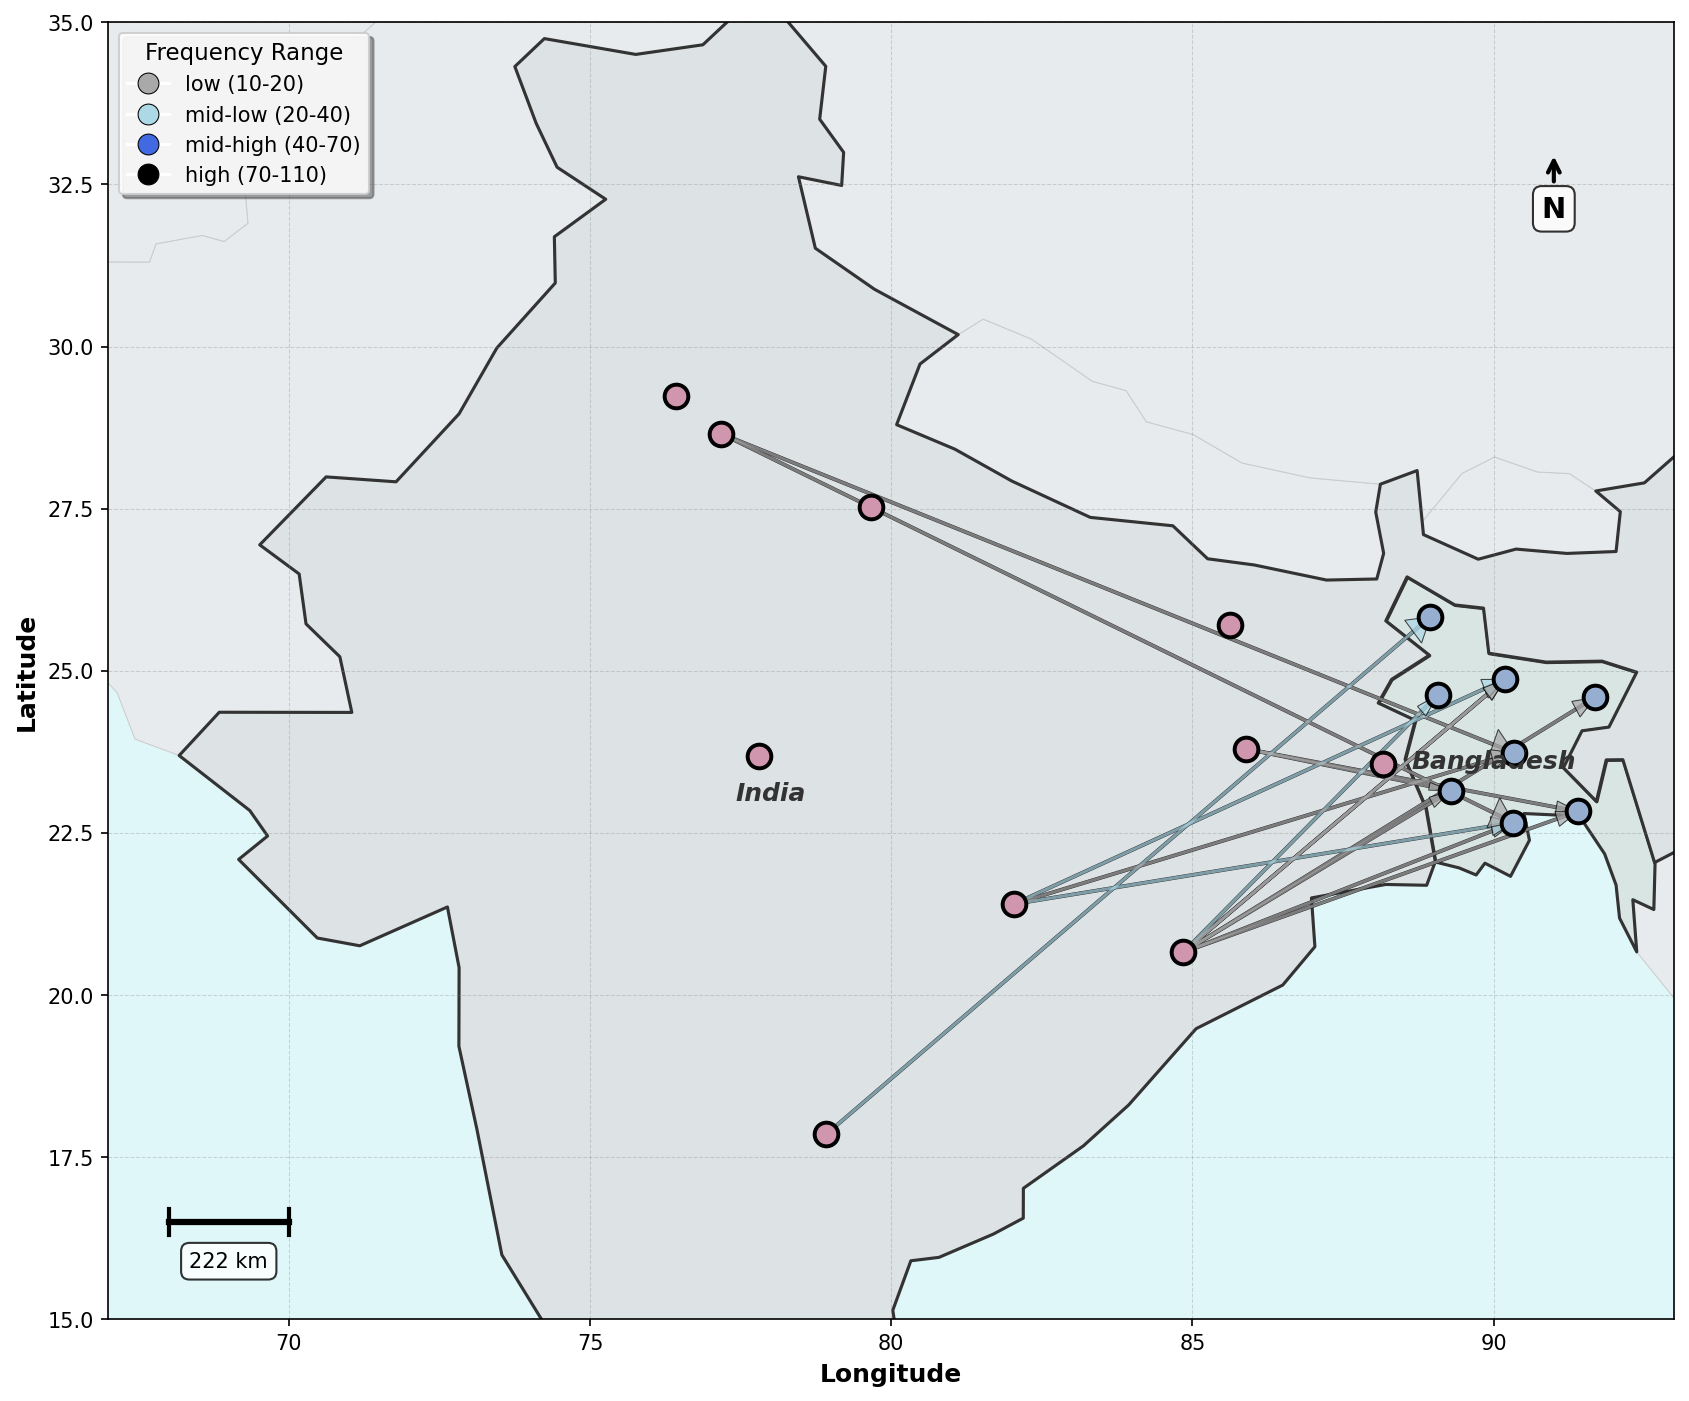

In [71]:
import warnings
warnings.filterwarnings('ignore', message='.*Shapely.*')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Polygon
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np

def geopandas_arrow_map(geo_points, lag_stats_df):
    """
    Create a map with arrows showing leader-follower relationships

    Parameters:
    -----------
    geo_points : DataFrame
        DataFrame with Latitude, Longitude columns
    lag_stats_df : DataFrame
        DataFrame with leader/follower lat/lon and frequency columns
    """

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(12, 14), dpi=150)

    # Load world map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Define the region bounds
    minx, maxx = 67, 93
    miny, maxy = 15, 35

    # Plot the base map
    world.plot(ax=ax, color='#E8EBED', edgecolor='#CCCCCC', linewidth=0.5)

    # Highlight Bangladesh
    bangladesh = world[world.name == 'Bangladesh']
    bangladesh.plot(ax=ax, color='#D8E5E3', edgecolor='#333333', linewidth=1.5)

    # Highlight India
    india = world[world.name == 'India']
    india.plot(ax=ax, color='#DDE3E5', edgecolor='#333333', linewidth=1.5)

    # Plot ocean/water color as background
    ax.set_facecolor('#E0F7FA')

    # Plot geo points (light grey markers)
    ax.scatter(geo_points.Longitude, geo_points.Latitude,
              s=150, c='black', zorder=3, label=None)

    geo_points_bd = geo_points[geo_points.Country=='Bangladesh']
    geo_points_ind = geo_points[geo_points.Country=='India']

    ax.scatter(geo_points_bd.Longitude, geo_points_bd.Latitude,
              s=100, c='#96AED0', zorder=4, label=None,
              edgecolors='black', linewidths=0.5)

    ax.scatter(geo_points_ind.Longitude, geo_points_ind.Latitude,
          s=100, c='#D096AE', zorder=4, label=None,
          edgecolors='black', linewidths=0.5)

    # Define custom bins for frequency
    custom_bins = [10, 20, 40, 70, 110]
    bin_labels = ["low", "mid-low", "mid-high", "high"]

    # Create bins for frequency
    bins = pd.cut(lag_stats_df['frequency'], bins=custom_bins,
                  labels=bin_labels, right=True)

    # Define color map
    color_map = {
        "low": "darkgrey",
        "mid-low": "lightblue",
        "mid-high": "royalblue",
        "high": "black"
    }

    # Get bin ranges for legend
    bin_ranges = {
        "low": (custom_bins[0], custom_bins[1]),
        "mid-low": (custom_bins[1], custom_bins[2]),
        "mid-high": (custom_bins[2], custom_bins[3]),
        "high": (custom_bins[3], custom_bins[4])
    }

    # Arrow parameters
    arrow_length_ratio = 1.1 / 3
    arrow_width = 0.035 / 2

    # Draw arrows for each leader-follower relationship
    for idx, row in lag_stats_df.iterrows():
        # Get coordinates
        leader_lon, leader_lat = row['leader_Longitude'], row['leader_Latitude']
        follower_lon, follower_lat = row['follower_Longitude'], row['follower_Latitude']

        # Get color based on frequency bin
        color = color_map[bins[idx]]

        # Draw black border for line (thicker, underneath)
        ax.plot([leader_lon, follower_lon],
               [leader_lat, follower_lat],
               color='black', linewidth=1.8, alpha=0.9, zorder=2)

        # Draw colored line from leader to follower (on top)
        ax.plot([leader_lon, follower_lon],
               [leader_lat, follower_lat],
               color=color, linewidth=1.5, alpha=0.7, zorder=2.1)

        # Calculate arrow head
        A = np.array([leader_lon, leader_lat])
        B = np.array([follower_lon, follower_lat])
        v = B - A
        v_norm = np.linalg.norm(v)

        if v_norm > 0:
            w = v / v_norm
            u = np.array([-v[1], v[0]])  # perpendicular vector

            # Arrow tip position
            P = B - arrow_length_ratio * w
            S = P - arrow_width * u
            T = P + arrow_width * u

            # Create arrow head polygon with black border
            arrow_head = Polygon([S, T, B],
                                closed=True,
                                facecolor=color,
                                edgecolor='black',
                                linewidth=0.5,
                                alpha=0.7,
                                zorder=2.2)
            ax.add_patch(arrow_head)

    # Set map bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.3, color='gray', linewidth=0.5)

    # Labels and title
    ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
    ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
    # ax.set_title('Geographic Distribution with Leader-Follower Relationships',
    #              fontsize=14, fontweight='bold', pad=20)

    # Create legend for frequency bins
    legend_elements = []
    for label, color in color_map.items():
        min_range, max_range = bin_ranges[label]
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w',
                  markerfacecolor=color, markersize=10,
                  markeredgecolor='black', markeredgewidth=0.5,
                  label=f"{label} ({min_range:.0f}-{max_range:.0f})")
        )

    ax.legend(handles=legend_elements,
             title='Frequency Range',
             loc='upper left',
             fontsize=10,
             title_fontsize=11,
             frameon=True,
             fancybox=True,
             shadow=True,
             framealpha=0.9)

    # Add scale bar
    scale_length_degrees = 2.0
    scale_km = int(scale_length_degrees * 111)
    scale_x = minx + 1
    scale_y = miny + 1.5

    ax.plot([scale_x, scale_x + scale_length_degrees], [scale_y, scale_y],
            'k-', linewidth=3, zorder=6)
    ax.plot([scale_x, scale_x], [scale_y - 0.2, scale_y + 0.2],
            'k-', linewidth=2, zorder=6)
    ax.plot([scale_x + scale_length_degrees, scale_x + scale_length_degrees],
            [scale_y - 0.2, scale_y + 0.2], 'k-', linewidth=2, zorder=6)
    ax.text(scale_x + scale_length_degrees/2, scale_y - 0.7,
            f'{scale_km} km', ha='center', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                     edgecolor='black', alpha=0.8))

    # Add country labels
    ax.text(90, 23.5, 'Bangladesh',
            fontsize=12, fontweight='bold',
            ha='center', style='italic',
            color='#333333')

    ax.text(78, 23, 'India',
            fontsize=12, fontweight='bold',
            ha='center', style='italic',
            color='#333333')

    # Add north arrow
    arrow_x = maxx - 2
    arrow_y = maxy - 3
    ax.annotate('N', xy=(arrow_x, arrow_y + 1),
               xytext=(arrow_x, arrow_y),
               fontsize=14, fontweight='bold', ha='center',
               arrowprops=dict(arrowstyle='->', lw=2, color='black'),
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                        edgecolor='black', alpha=0.8))

    # Adjust layout
    plt.subplots_adjust(left=0.08, right=0.95, top=0.95, bottom=0.08)
    plt.show()

    return fig, ax


# Example usage:
# Make sure metadata_region_all and lag_stats dataframe are defined
# metadata_region_all should have Latitude, Longitude columns
# lag_stats should have: leader_Longitude, leader_Latitude,
#                        follower_Longitude, follower_Latitude, frequency

# Call the function
fig, ax = geopandas_arrow_map(
    metadata_region_all,
    lag_stats_df_single_period_non_zero_evidence_df_frequent.sample(15)
)

# Optional: Save
# fig.savefig('arrow_map.png', dpi=300, bbox_inches='tight')
# fig.savefig('arrow_map.pdf', bbox_inches='tight')

Fall


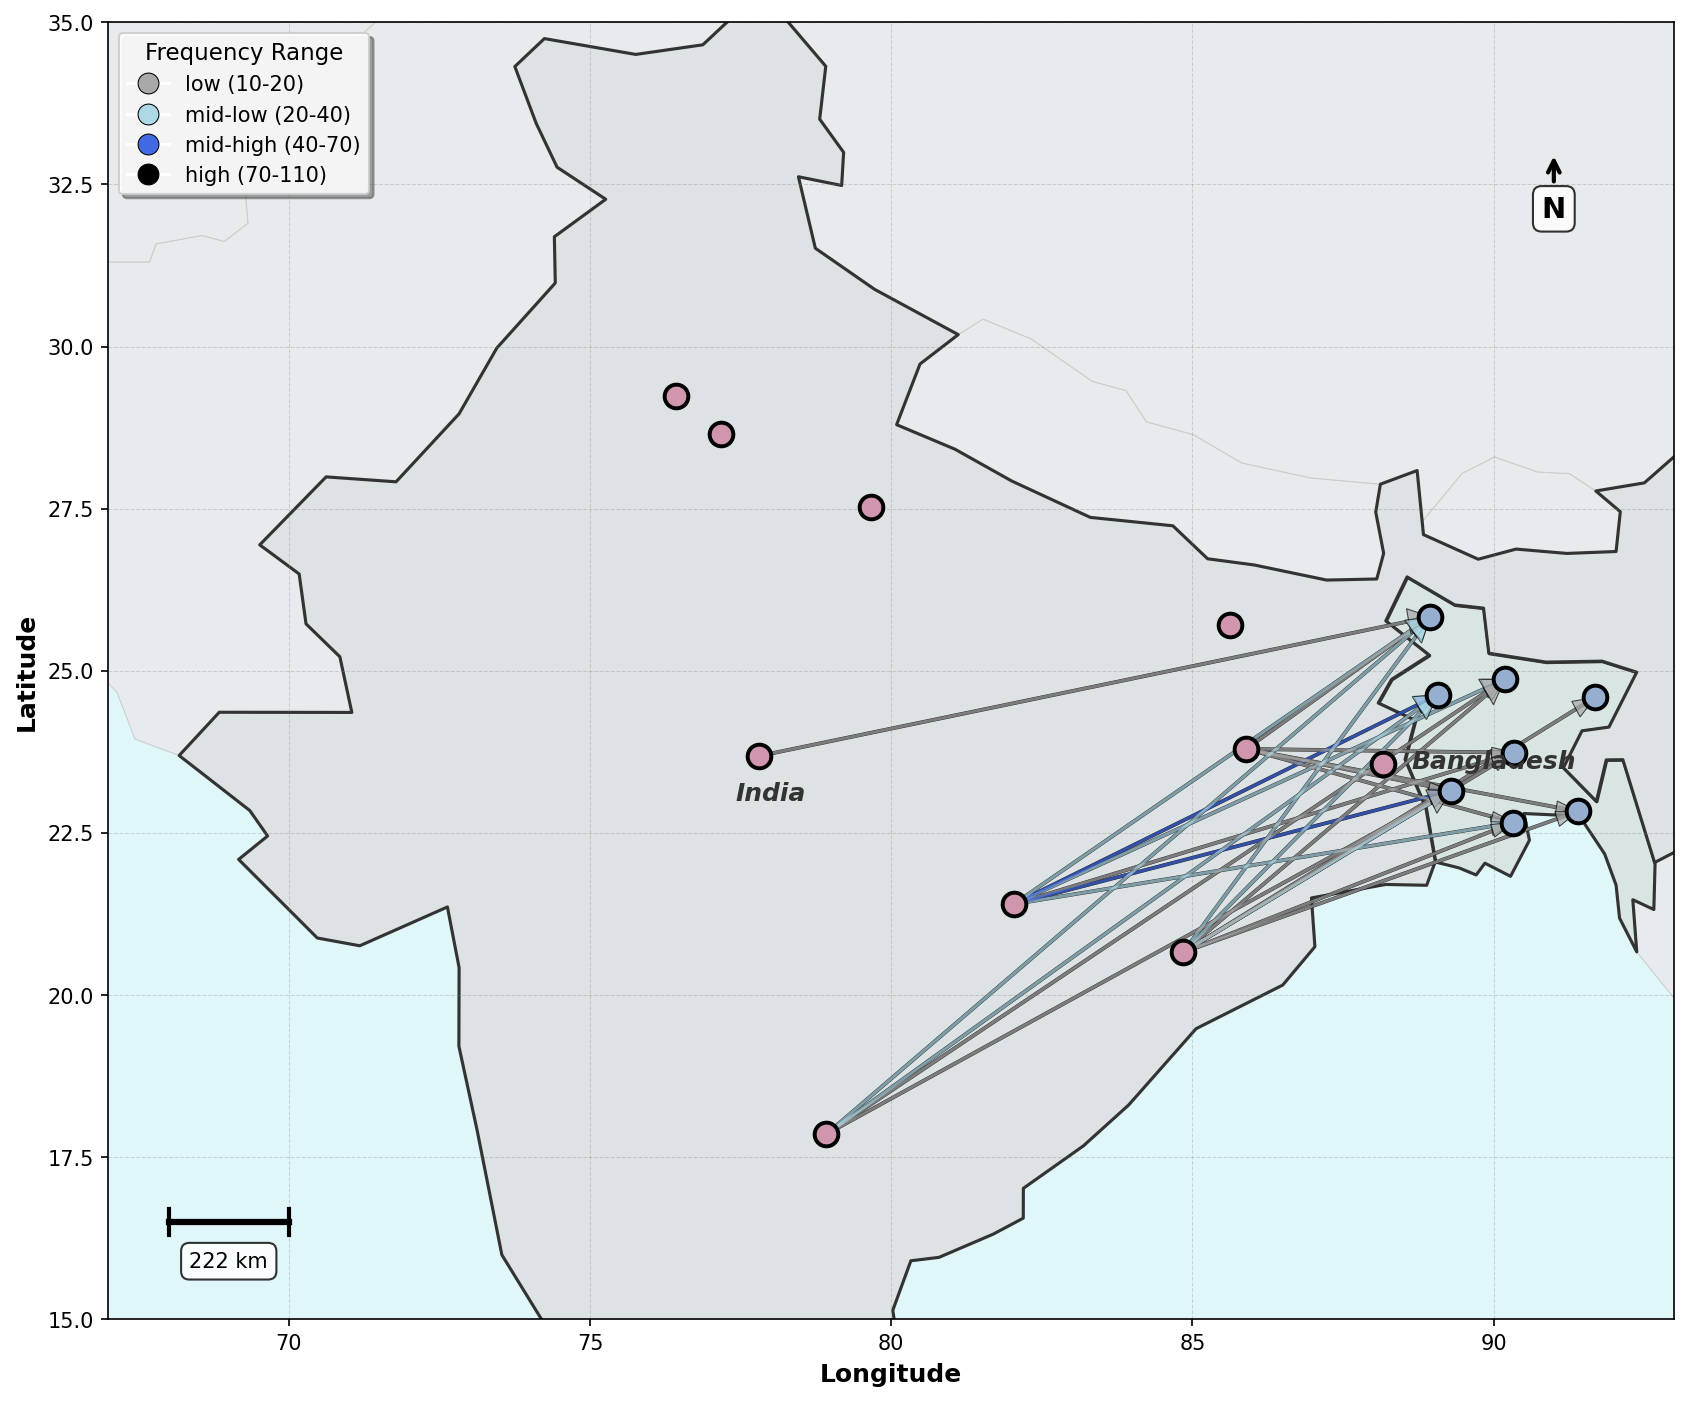

Spring


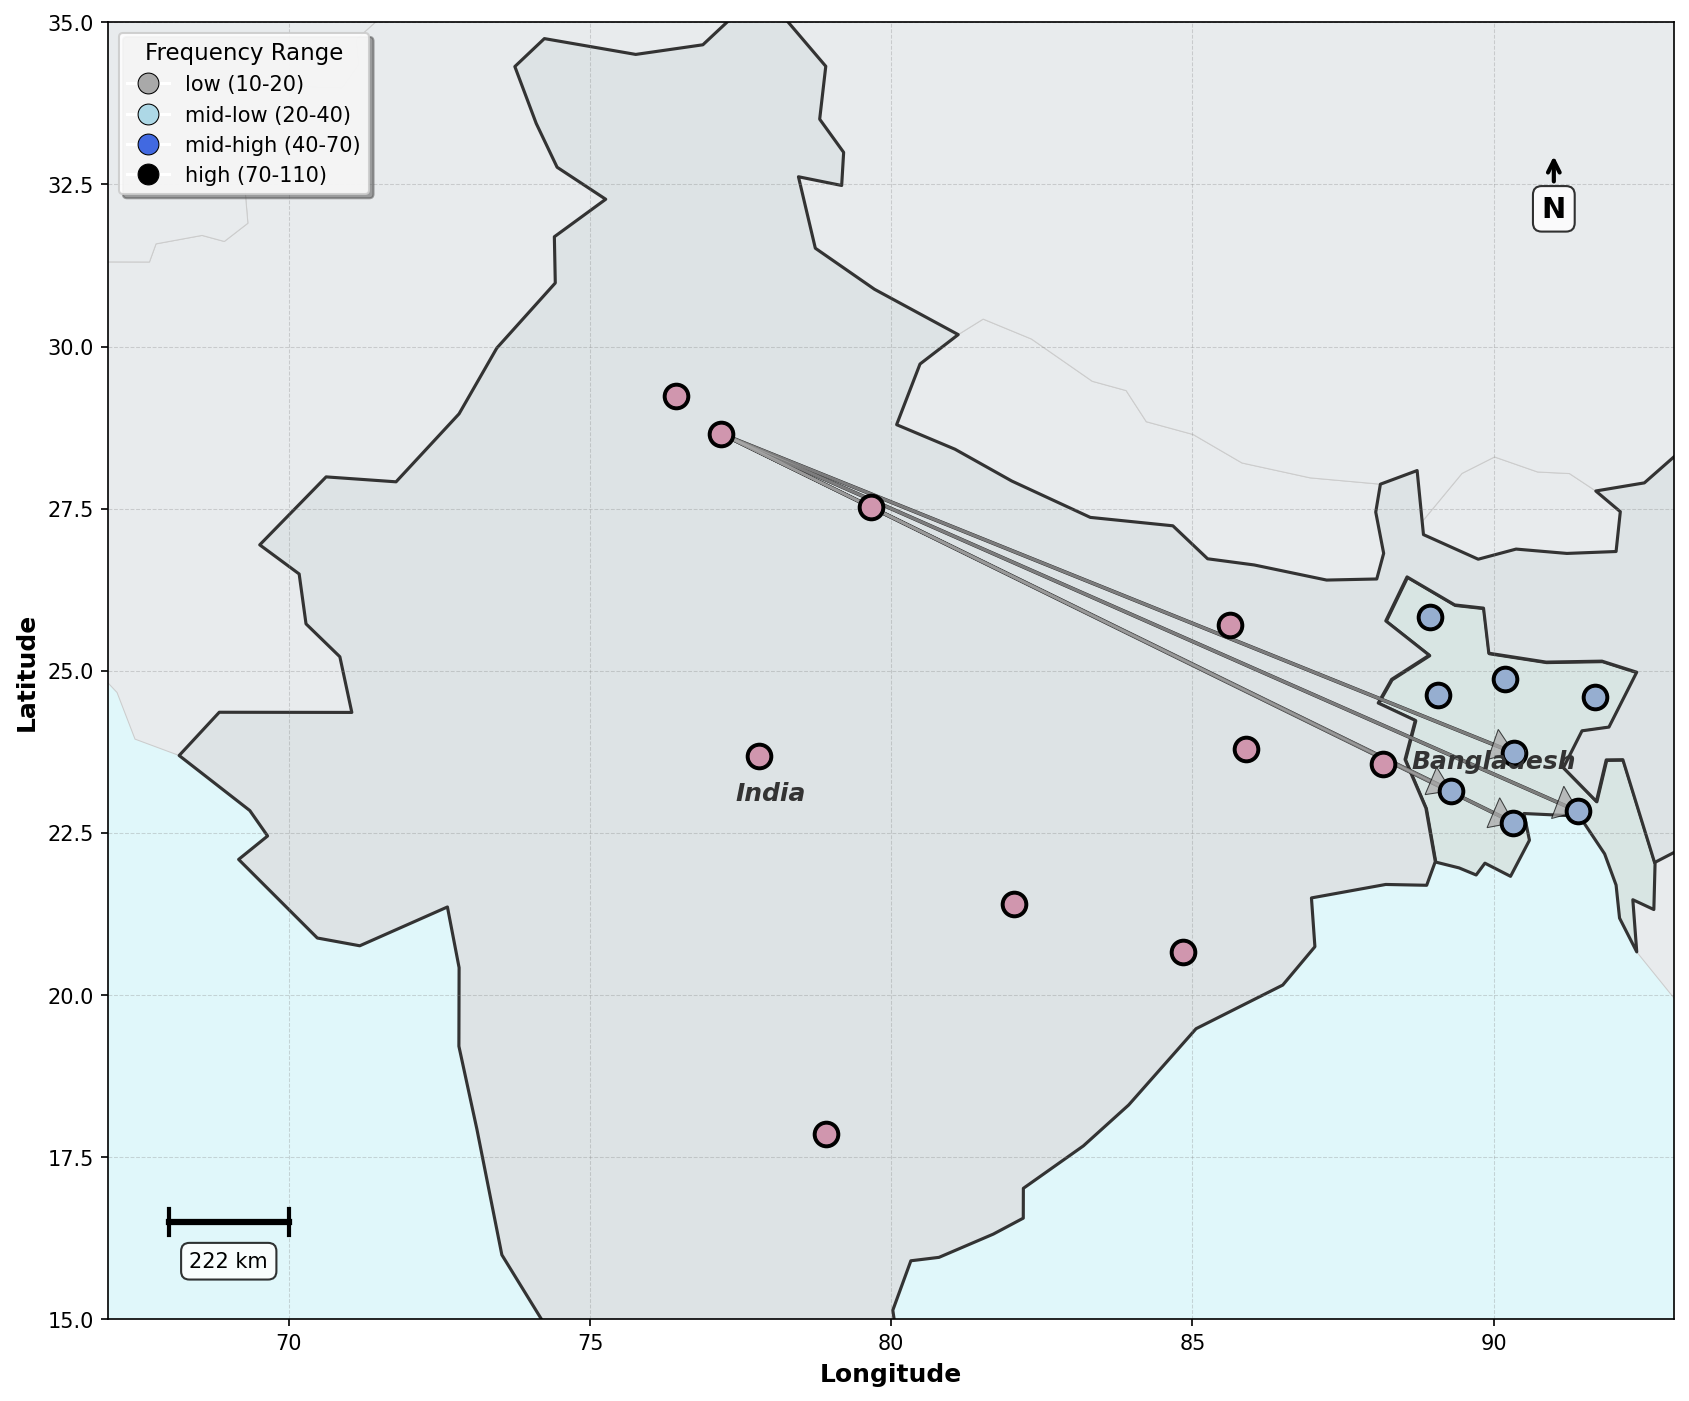

Summer


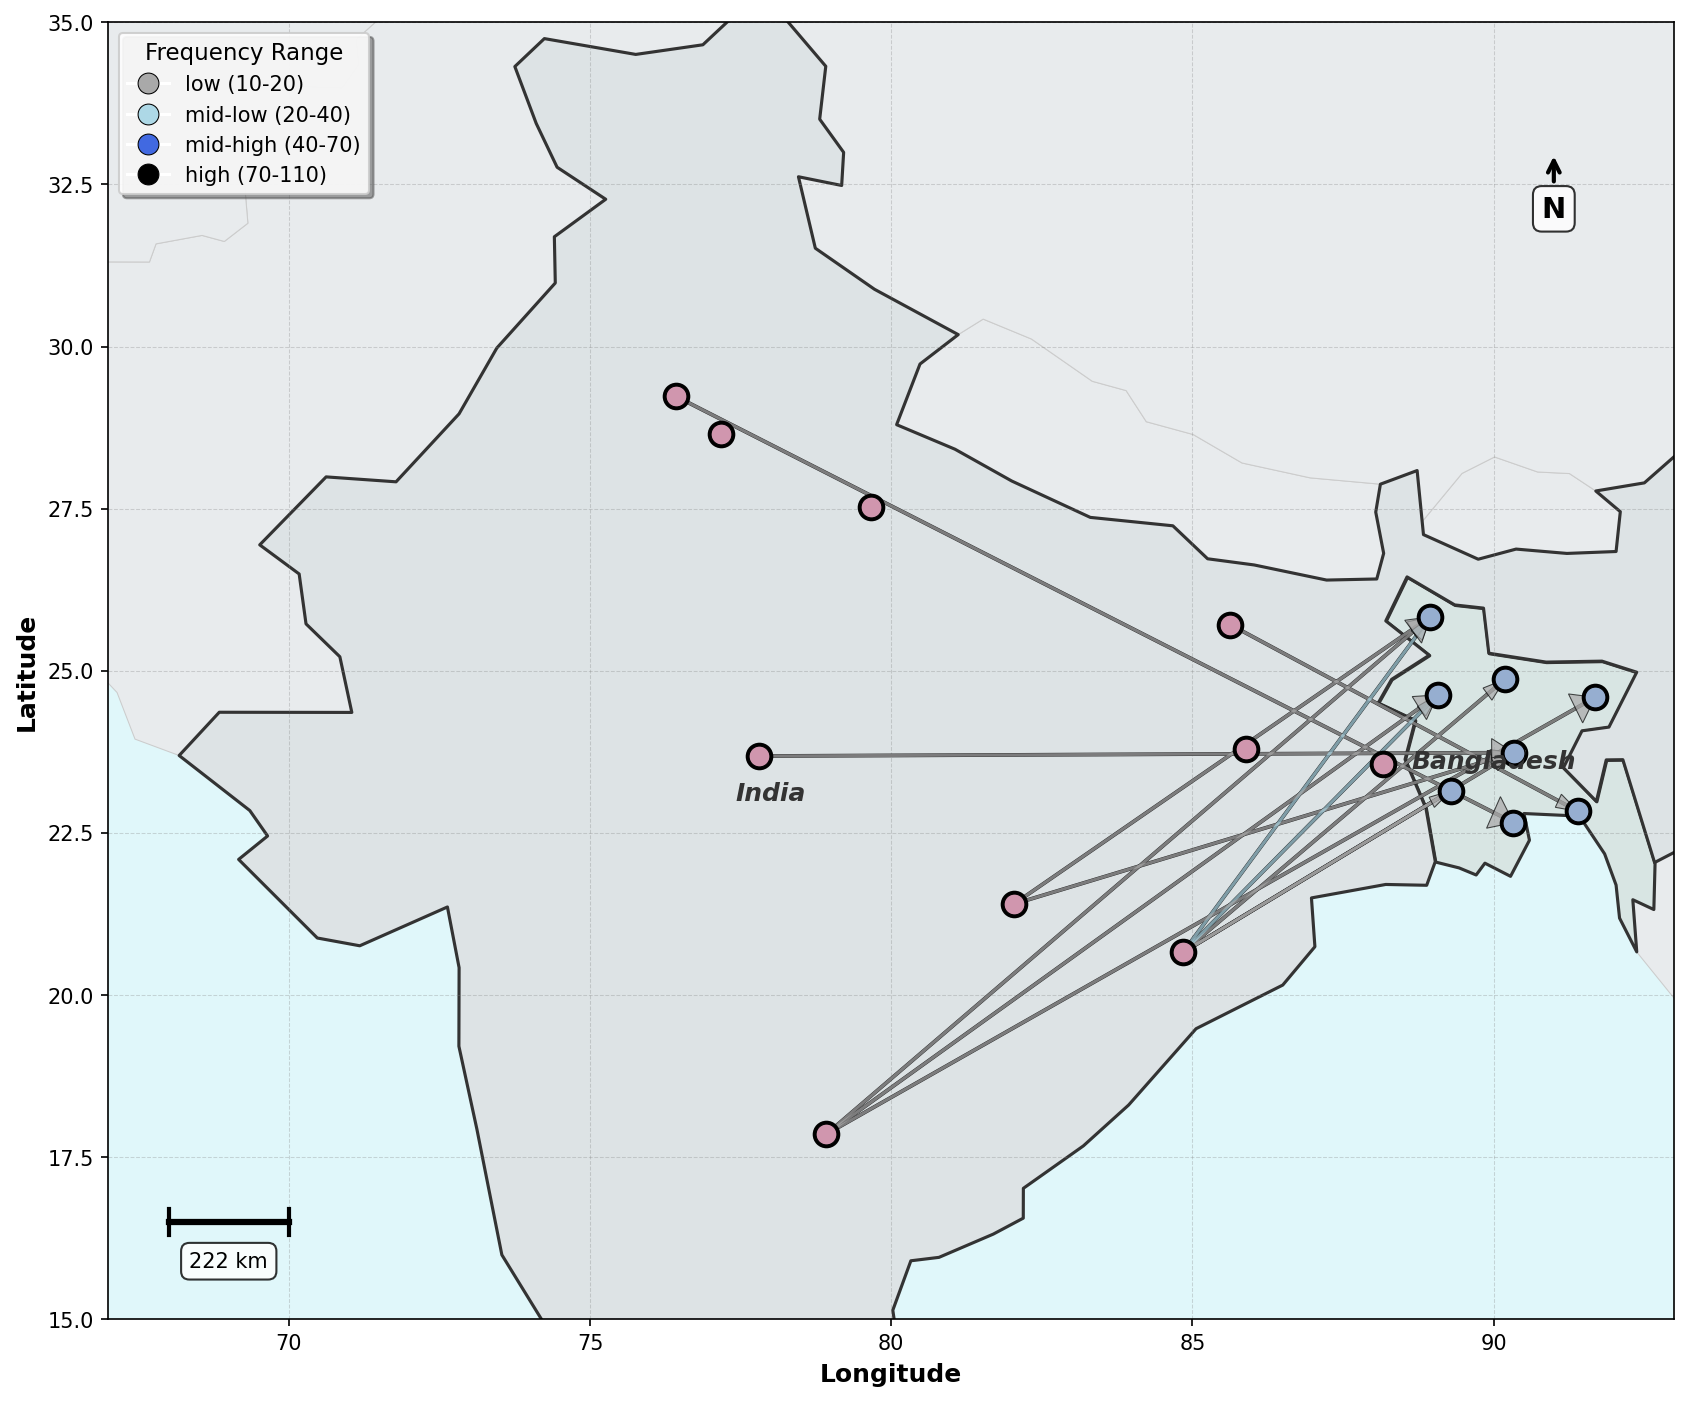

Winter


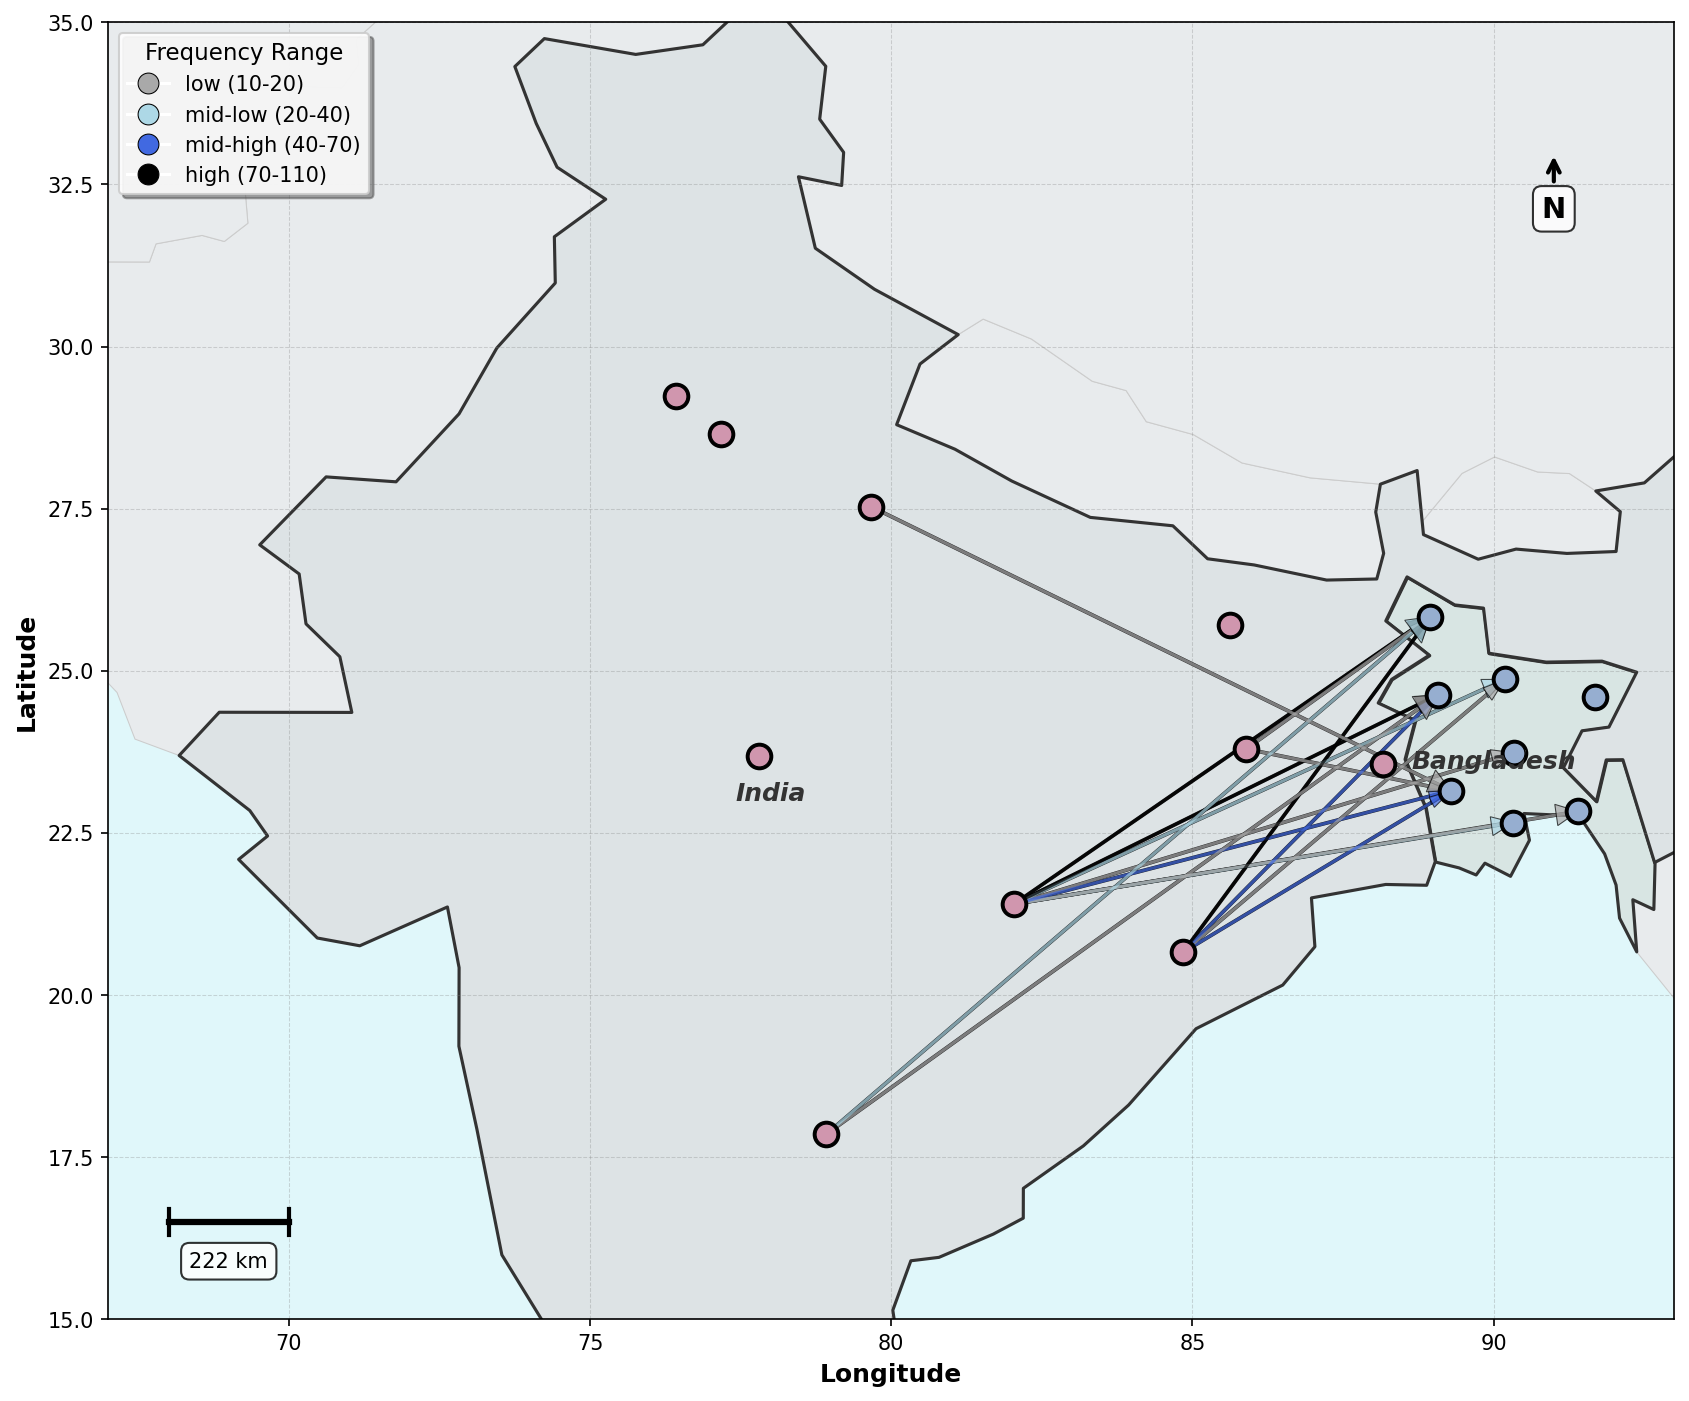

In [72]:
for grp,lag_stats_df_single_period_non_zero_evidence_df_frequent_seasonal in lag_stats_df_single_period_non_zero_evidence_df_frequent.groupby('season'):
    print(grp)
    # plotly_marker_scatter_mapbox_with_arrow(metadata_region_all, lag_stats_df_single_period_non_zero_evidence_df_frequent_seasonal)
    geopandas_arrow_map(metadata_region_all, lag_stats_df_single_period_non_zero_evidence_df_frequent_seasonal)

In [ ]:
lag_stats_df_single_period_non_zero_evidence_df.columns

In [ ]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

def plotly_marker_scatter_mapbox_with_arrow(geo_points, lag_stats_df_single_period_non_zero_with_lat_lon):
    mapbox_access_token = 'pk.eyJ1IjoiaG9vbmtlbmc5MyIsImEiOiJjam43cGhpNng2ZmpxM3JxY3Z4ODl2NWo3In0.SGRvJlToMtgRxw9ZWzPFrA'
    seasons = lag_stats_df_single_period_non_zero_with_lat_lon['season'].unique()

    # Create subplot structure (2x2 for 4 seasons)
    fig = go.Figure()

    season_positions = {
        'Spring': (1, 1),
        'Summer': (1, 2),
        'Fall': (2, 1),
        'Winter': (2, 2)
    }

    # Normalize max_correlation for coloring
    lag_stats_df_single_period_non_zero_with_lat_lon['color_intensity'] = (
        lag_stats_df_single_period_non_zero_with_lat_lon['max_correlation'] -
        lag_stats_df_single_period_non_zero_with_lat_lon['max_correlation'].min()
    ) / (
        lag_stats_df_single_period_non_zero_with_lat_lon['max_correlation'].max() -
        lag_stats_df_single_period_non_zero_with_lat_lon['max_correlation'].min()
    )

    for season in seasons:
        subset = lag_stats_df_single_period_non_zero_with_lat_lon[
            lag_stats_df_single_period_non_zero_with_lat_lon['season'] == season
        ]

        for idx, row in subset.iterrows():
            A = np.array([row['leader_Longitude'], row['leader_Latitude']])
            B = np.array([row['follower_Longitude'], row['follower_Latitude']])
            v = B - A
            w = v / np.linalg.norm(v)
            u = np.array([-v[1], v[0]])  # u orthogonal to w

            # Arrow properties
            l = 1.1 / 3
            width = 0.035 / 2
            P = B - l * w
            S = P - width * u
            T = P + width * u

            # Dynamic color based on max_correlation
            intensity = row['color_intensity']
            color = f'rgba(65, 105, 225, {0.5 + 0.5 * intensity})'  # Royal blue gradient

            # Line thickness based on max_correlation_lag
            line_thickness = row['max_correlation_lag']

            # Arrow as a filled polygon
            fig.add_trace(go.Scattermapbox(
                lon=[S[0], T[0], B[0], S[0]],
                lat=[S[1], T[1], B[1], S[1]],
                mode='lines',
                fill='toself',
                fillcolor=color,
                opacity=0.6,
                line=dict(color=color, width=line_thickness),
                subplot=f"mapbox{season_positions[season][0]}{season_positions[season][1]}"
            ))

            # Connecting line
            fig.add_trace(go.Scattermapbox(
                lon=[row['leader_Longitude'], row['follower_Longitude']],
                lat=[row['leader_Latitude'], row['follower_Latitude']],
                mode='lines',
                line=dict(color=color, width=line_thickness),
                opacity=0.6,
                subplot=f"mapbox{season_positions[season][0]}{season_positions[season][1]}"
            ))

    fig.update_layout(
        height=900,
        width=900,
        title="Scatter Map with Arrows for Each Season",
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=go.layout.mapbox.Center(lat=23.81, lon=84.3),
            pitch=0,
            zoom=4.5
        ),
        grid=dict(rows=2, columns=2, pattern="independent")
    )

    fig.show(renderer="browser")
    # print(fig)

metadata_region_all['color'] = metadata_region_all.apply(lambda x: country_color_dict[x.Country],axis=1)
# plotly_marker_scatter_mapbox_with_arrow(metadata_region_all,lag_stats_df_single_period_non_zero_with_lat_lon)
plotly_marker_scatter_mapbox_with_arrow(metadata_region_all,lag_stats_df_single_period_non_zero_evidence_df.sample(10))

In [ ]:

def plotly_marker_scatter_mapbox_with_seasonal_correlation(
    geo_points,
    lag_stats_df_single_period_non_zero_with_lat_lon
):
    # Mapbox access token (consider using a more secure method in production)
    mapbox_access_token = 'pk.eyJ1IjoiaG9vbmtlbmc5MyIsImEiOiJjam43cGhpNng2ZmpxM3JxY3Z4ODl2NWo3In0.SGRvJlToMtgRxw9ZWzPFrA'

    # Get unique seasons
    seasons = lag_stats_df_single_period_non_zero_with_lat_lon['season'].unique()

    # Create subplot figure
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=seasons,
        specs=[[{'type': 'mapbox'}, {'type': 'mapbox'}],
               [{'type': 'mapbox'}, {'type': 'mapbox'}]]
    )

    # Color mapping function for correlation intensity
    def get_correlation_color(correlation):
        # Normalize correlation to create a color gradient from light to deep royal blue
        # Assuming correlation is between 0 and 1
        intensity = min(max(correlation, 0), 1)
        r = int(135 * (1 - intensity) + 65 * intensity)  # Royal blue R component
        g = int(206 * (1 - intensity) + 105 * intensity)  # Royal blue G component
        b = int(235 * (1 - intensity) + 30 * intensity)  # Royal blue B component
        return f'rgb({r},{g},{b})'

    # Iterate through seasons
    for idx, season in enumerate(seasons, 1):
        # Filter data for current season
        season_data = lag_stats_df_single_period_non_zero_with_lat_lon[
            lag_stats_df_single_period_non_zero_with_lat_lon['season'] == season
        ]

        # Row and column for subplot
        row = (idx - 1) // 2 + 1
        col = (idx - 1) % 2 + 1

        # Add base markers
        fig.add_trace(
            go.Scattermapbox(
                lat=geo_points.Latitude,
                lon=geo_points.Longitude,
                mode='markers',
                marker=dict(
                    size=15,
                    color='black'
                ),
                showlegend=False
            ),
            row=row, col=col
        )

        # Add colored markers
        fig.add_trace(
            go.Scattermapbox(
                lat=geo_points.Latitude,
                lon=geo_points.Longitude,
                mode='markers',
                marker=dict(
                    size=12,
                    color=geo_points.color
                ),
                text=geo_points.index,
                showlegend=False
            ),
            row=row, col=col
        )

        # Add arrows and connection lines with correlation-based coloring
        l = 1.1/3  # arrow length
        width = 0.035/2  # 2*width is the width of the arrow base as triangle

        for _, leader_follower_zone in season_data.iterrows():
            # Calculate arrow coordinates
            A = np.array([
                leader_follower_zone.leader_Longitude,
                leader_follower_zone.leader_Latitude
            ])
            B = np.array([
                leader_follower_zone.follower_Longitude,
                leader_follower_zone.follower_Latitude
            ])

            v = B - A
            w = v / np.linalg.norm(v)
            u = np.array([-v[1], v[0]])

            P = B - l * w
            S = P - width * u
            T = P + width * u

            # Get color based on max correlation
            correlation_color = get_correlation_color(
                leader_follower_zone.max_correlation
            )

            # Add arrow
            fig.add_trace(
                go.Scattermapbox(
                    lon=[S[0], T[0], B[0], S[0]],
                    lat=[S[1], T[1], B[1], S[1]],
                    mode='lines',
                    fill='toself',
                    opacity=0.5,
                    fillcolor=correlation_color,
                    line_color=correlation_color
                ),
                row=row, col=col
            )

            # Add connection line
            fig.add_trace(
                go.Scattermapbox(
                    lon=[
                        leader_follower_zone.leader_Longitude,
                        leader_follower_zone.follower_Longitude
                    ],
                    lat=[
                        leader_follower_zone.leader_Latitude,
                        leader_follower_zone.follower_Latitude
                    ],
                    mode='lines',
                    opacity=0.5,
                    line_color=correlation_color
                ),
                row=row, col=col
            )

        # Update mapbox layout for each subplot
        fig.update_layout(
            **{f'mapbox{idx}': dict(
                accesstoken=mapbox_access_token,
                bearing=0,
                center=dict(lat=23.81, lon=84.3),
                pitch=0,
                zoom=4.5
            ) for idx in range(1, 5)}
        )

    # Overall figure layout
    fig.update_layout(
        height=1200,
        width=1200,
        hovermode='closest',
        title_text="Seasonal Correlation Visualization"
    )

    fig.show()


In [ ]:
# metadata_region_all

# Trial Analysis

In [ ]:
from itertools import combinations

window, step, lag_range = 168, 24*7, 12
range_iter = range(-lag_range,lag_range+1)

all_stat = []
for start_idx in range(0,series_for_cc.shape[0]-step,step):
    end_idx = start_idx+window
    series_window_for_cc = series_for_cc[start_idx:end_idx]
    # print(start_idx,end_idx)

    time_window_stat = []
    for leader,follower in combinations(series_for_cc.columns, 2):
        # print(leader,follower)
        cross_corr = pd.Series([series_window_for_cc[follower].corr(series_window_for_cc[leader].shift(j)) for j in range_iter], index=range_iter)
        time_window_stat.append([leader,follower,cross_corr])
    all_stat.append(time_window_stat)
    print(all_stat)

In [ ]:
len(all_stat[0][0][2])

In [ ]:
metadata_region_all

In [ ]:
region_series_all.index

In [ ]:
region_series_india = region_series_all[region_series_all[metadata_region_all.Country=='India'].index]
region_series_india

In [ ]:
region_series_india = region_series_india.shift(1)


In [ ]:
range_iter = range(0, 12 + 1)
for time_segment, subseries in region_series_all.resample('W'):
    # print(time_segment)
    cross_corr = pd.Series([subseries.Dhaka.shift(j).corr(subseries['West Bengal']) for j in range_iter], index=range_iter)
    # print(subseries.shape)
    if cross_corr.max()<.3 or cross_corr.idxmax()==0: continue
    print(time_segment,cross_corr.idxmax(),cross_corr.max())
    # fig = px.bar(cross_corr)
    # fig.show()